# hotel-booking-demand Portfolio Project

## Introduction

This Jupyter notebook is a demonstration of data science skills on hotel bookings data set. The data was used by [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand) and originally published on [ScienceDirect](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

## The Business Problem - Cancellations

Reservation cancellations cost hotels money. Hotel reservations are an opportunity cost. A room reserved by one customer cannot be sold to another. If a customer cancels the reservation, the hotel risks not being able to rent it out in time to another customer. In this data set, about 37% of reservations are cancelled. If the hotels could predict which reservations were likely to cancel, they might use some risk mitigation strategies such as charging a non-refundable deposit or overbooking a certain percentage of the rooms. This notebook will create and evaluate a predictive model for booking cancellations.

## Sections of this Jupyter Notebook
1. Data Cleaning and Wrangling
    - Reading in the data from a CSV file into a pandas dataframe
    - Looking at the data types and values
    - Fixing wrong types on data columns
    - Imputing missing values
    - Data transformations (numpy)
    - Exporting to a CSV file
2. Exploratory Data Analysis (EDA)
    - Univariate data analysis and plots (seaborn, matplotlib)
    - Bivariate data analysis and plots  (seaborn, matplotlib)
        - Correlation Heatmap
        - Histograms Grouped by is_canceled
        - Hitograms Grouped by adr (Average Daily Rate for the hotel room)
    - ANOVA analysis on cancellations    (statsmodels)
3. Predictive Modeling of Cancellations
    - Logistic Regression (sklearn)
    - Random Forest Classifier
    - Artificial Neural Network
4. Conclusions and Recommendations for the Hotel

In [1]:
# import the libaries we'll need
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# double check our working directory to make sure it's in the same place as the CSV file
os.getcwd()

'/home/darryl/code/Github/hotel-booking-demand'

In [3]:
# read in the data file and look at the first few rows
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# look at the data types so we can compare to the ScienceDirect paper's variable descriptions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
# helper function for viewing pandas dataframes simlar to R's glimpse() function
# https://stackoverflow.com/questions/27637281/what-are-python-pandas-equivalents-for-r-functions-like-str-summary-and-he
def glimpse_pd(df, max_width=76):

    # find the max string lengths of the column names and dtypes for formatting
    _max_len = max([len(col) for col in df])
    _max_dtype_label_len = max([len(str(df[col].dtype)) for col in df])

    # print the dimensions of the dataframe
    print(f"{type(df)}:  {df.shape[0]} rows of {df.shape[1]} columns")

    # print the name, dtype and first few values of each column
    for _column in df:

        _col_vals = df[_column].head(max_width).to_list()
        _col_type = str(df[_column].dtype)

        output_col = f"{_column}:".ljust(_max_len+1, ' ')
        output_dtype = f" {_col_type}".ljust(_max_dtype_label_len+3, ' ')

        output_combined = f"{output_col} {output_dtype} {_col_vals}"

        # trim the output if too long
        if len(output_combined) > max_width:
            output_combined = output_combined[0:(max_width-4)] + " ..."

        print(output_combined)

In [6]:
glimpse_pd(df, 120)

<class 'pandas.core.frame.DataFrame'>:  119390 rows of 32 columns
hotel:                           object    ['Resort Hotel', 'Resort Hotel', 'Resort Hotel', 'Resort Hotel', 'Resort  ...
is_canceled:                     int64     [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  ...
lead_time:                       int64     [342, 737, 7, 13, 14, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 68, 37, 12, 0 ...
arrival_date_year:               int64     [2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,  ...
arrival_date_month:              object    ['July', 'July', 'July', 'July', 'July', 'July', 'July', 'July', 'July',  ...
arrival_date_week_number:        int64     [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  ...
arrival_date_day_of_month:       int64     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  ...
stays_in_weekend_nights:         int64     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
# get some descriptive statistics 
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [8]:
# count the number of missing data values and unique values
missing = {}

for (columnName, columnData) in df.items():
    print('Column Name : ', columnName)
    num_missing =  sum(columnData.isnull())
    print('Number of Missing Values : ', num_missing)
    if num_missing > 0:
        missing[columnName] = num_missing
    print('Unique Values : ', columnData.sort_values().unique())
    print('Number of Unique Values : ', len(columnData.unique()))
    
print(missing)

Column Name :  hotel
Number of Missing Values :  0
Unique Values :  ['City Hotel' 'Resort Hotel']
Number of Unique Values :  2
Column Name :  is_canceled
Number of Missing Values :  0
Unique Values :  [0 1]
Number of Unique Values :  2
Column Name :  lead_time
Number of Missing Values :  0
Unique Values :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 17

Unique Values :  ['Contract' 'Group' 'Transient' 'Transient-Party']
Number of Unique Values :  4
Column Name :  adr
Number of Missing Values :  0
Unique Values :  [-6.38e+00  0.00e+00  2.60e-01 ...  5.08e+02  5.10e+02  5.40e+03]
Number of Unique Values :  8879
Column Name :  required_car_parking_spaces
Number of Missing Values :  0
Unique Values :  [0 1 2 3 8]
Number of Unique Values :  5
Column Name :  total_of_special_requests
Number of Missing Values :  0
Unique Values :  [0 1 2 3 4 5]
Number of Unique Values :  6
Column Name :  reservation_status
Number of Missing Values :  0
Unique Values :  ['Canceled' 'Check-Out' 'No-Show']
Number of Unique Values :  3
Column Name :  reservation_status_date
Number of Missing Values :  0
Unique Values :  ['2014-10-17' '2014-11-18' '2015-01-01' '2015-01-02' '2015-01-18'
 '2015-01-20' '2015-01-21' '2015-01-22' '2015-01-28' '2015-01-29'
 '2015-01-30' '2015-02-02' '2015-02-05' '2015-02-06' '2015-02-09'
 '2015-02-10' '2015-02-11' '2015-02-12' '2015-02

In [9]:
# Fix columns with wrong types and impute missing values

# The following are all IDs and thus should be integers
df['agent'] = df['agent'].fillna(0).astype(int) # NULL values mean not applicable. Will use 0 for the not applicable ID.
df['company'] = df['company'].fillna(0).astype(int) # NULL values mean not applicable. Will use 0 for the not applicable ID.

# Children should be an integer values, not float.
df['children'] = df['children'].fillna(0).astype(int) # NULL will be replaced by the median value, which is also the mode, 0.

# Missing country values will be replaced by 'UNK" for UNKNOWN should be an integer values, not float.
df['country'] = df['country'].fillna('UNK')

In [10]:
# Transform some of the data columns into more useful forms

# Univariate visualization showed that lead_time is not normally distributed so transform it using np.log1p()
df['lead_time_log1p'] = np.log(df['lead_time'] + 1)

# Group the following columns into binary classifications
df['has_agent'] = (df['agent'] > 0).astype(int)
df['has_company'] = (df['company'] > 0).astype(int)
df['has_children'] = (df['children'] > 0).astype(int)
df['has_babies'] = (df['babies'] > 0).astype(int)

In [11]:
# write out the cleaned file
df.to_csv('hotel-bookins-cleaned.csv', index=False)

## Exploratory Data Analysis (EDA)

### Univariate Plots

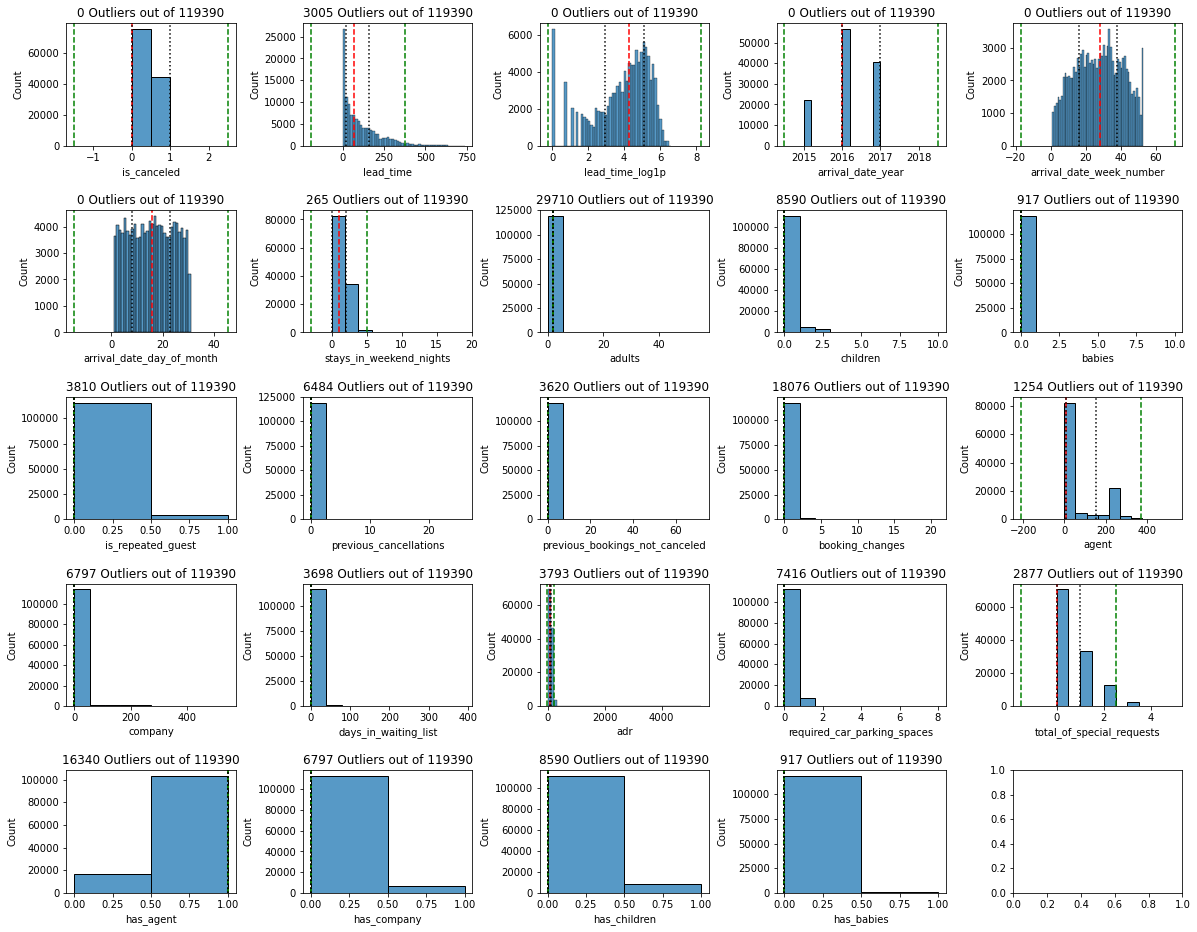

In [12]:
# Do univariate plots of the numeric columns
# The graphs are histograms
# The red line is the median
# The black lines are the 25% and 75% percentiles
# The green lines the outlier boundaries using 1.5 times the inter-quartile range

numeric_columns = ['is_canceled', 'lead_time', 'lead_time_log1p', 'arrival_date_year',  
       'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 
       'adults', 'children', 'babies', 'is_repeated_guest',
       'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'has_agent', 'has_company', 'has_children',
                  'has_babies']

num_rows = df.shape[0]

plt.rcParams['figure.figsize'] = [20, 16]
num_plots = len(numeric_columns)
plot_columns = int(np.round(np.sqrt(num_plots) + 0.5))
plot_rows = plot_columns
fig, axes = plt.subplots(plot_rows, plot_columns)
fig.subplots_adjust(hspace=0.525, wspace=0.4) # needed for whitespace between plots

for index, column_name in enumerate(numeric_columns):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    median = df[column_name].median()
    stdev = np.std(df[column_name])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    if column_name == 'arrival_date_week_number':
        bins = 52
    elif column_name == 'arrival_date_day_of_month':
        bins = 31
    elif column_name == 'lead_time' or column_name == 'lead_time_log1p':
        bins = 50
    elif column_name == 'adr':
        bins = 50
    elif column_name in ['is_canceled', 'is_repeated_guest','has_agent', 'has_company', 'has_children',
                  'has_babies']:
        bins = 2
    else:
        bins = 10
    outliers = sum((df[column_name] < lower_limit) | (df[column_name] > upper_limit))
    ax = sns.histplot(df[column_name], bins=bins, kde=False, ax=axes[index // plot_columns, index % plot_columns])
    # put in vertical lines to show the median in dashed red, 25% and 75% in dotted black, and outliers boundaries in dashed green
    ax.axvline(median, color="red", linestyle="dashed")
    ax.axvline(lower_limit, color="green", linestyle="dashed")
    ax.axvline(upper_limit, color="green", linestyle="dashed")
    ax.axvline(Q1, color="black", linestyle="dotted")
    ax.axvline(Q3, color="black", linestyle="dotted")
    title = f"{outliers} Outliers out of {num_rows}"
    ax.set(title=title)

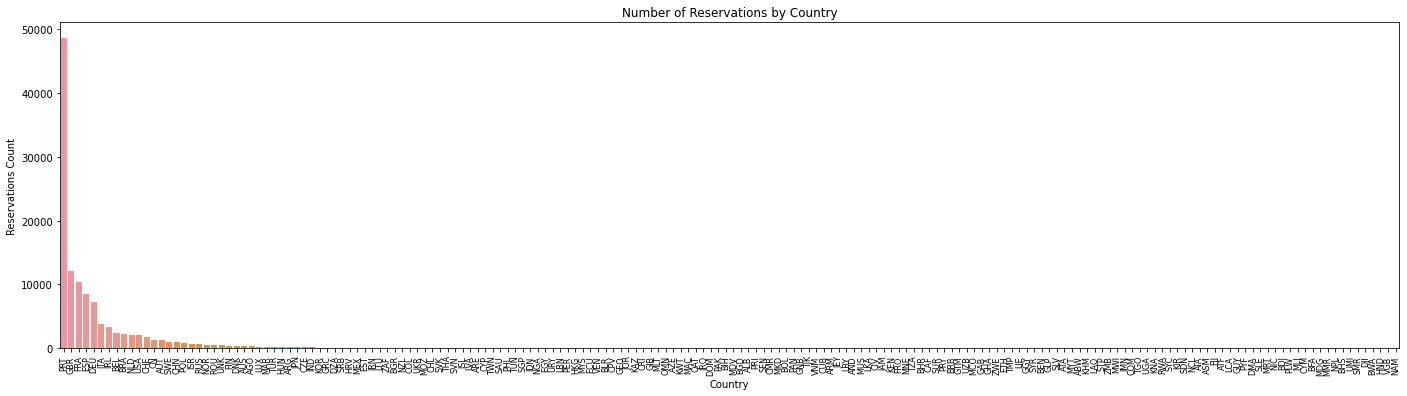

In [13]:
# Look at the distribution of reservations among countries. Portugal (PRT) is the largest.
# Count the occurrences of each value in the 'Category' column
value_counts = df['country'].value_counts()

# Create the bar plot using Seaborn
plt.figure(figsize=(24, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)

# Set the labels and title
plt.xlabel('Country')
plt.ylabel('Reservations Count')
plt.title('Number of Reservations by Country')
plt.xticks(rotation=90,fontsize=8)

# Show the plot
plt.show()


### Bivariate Plots

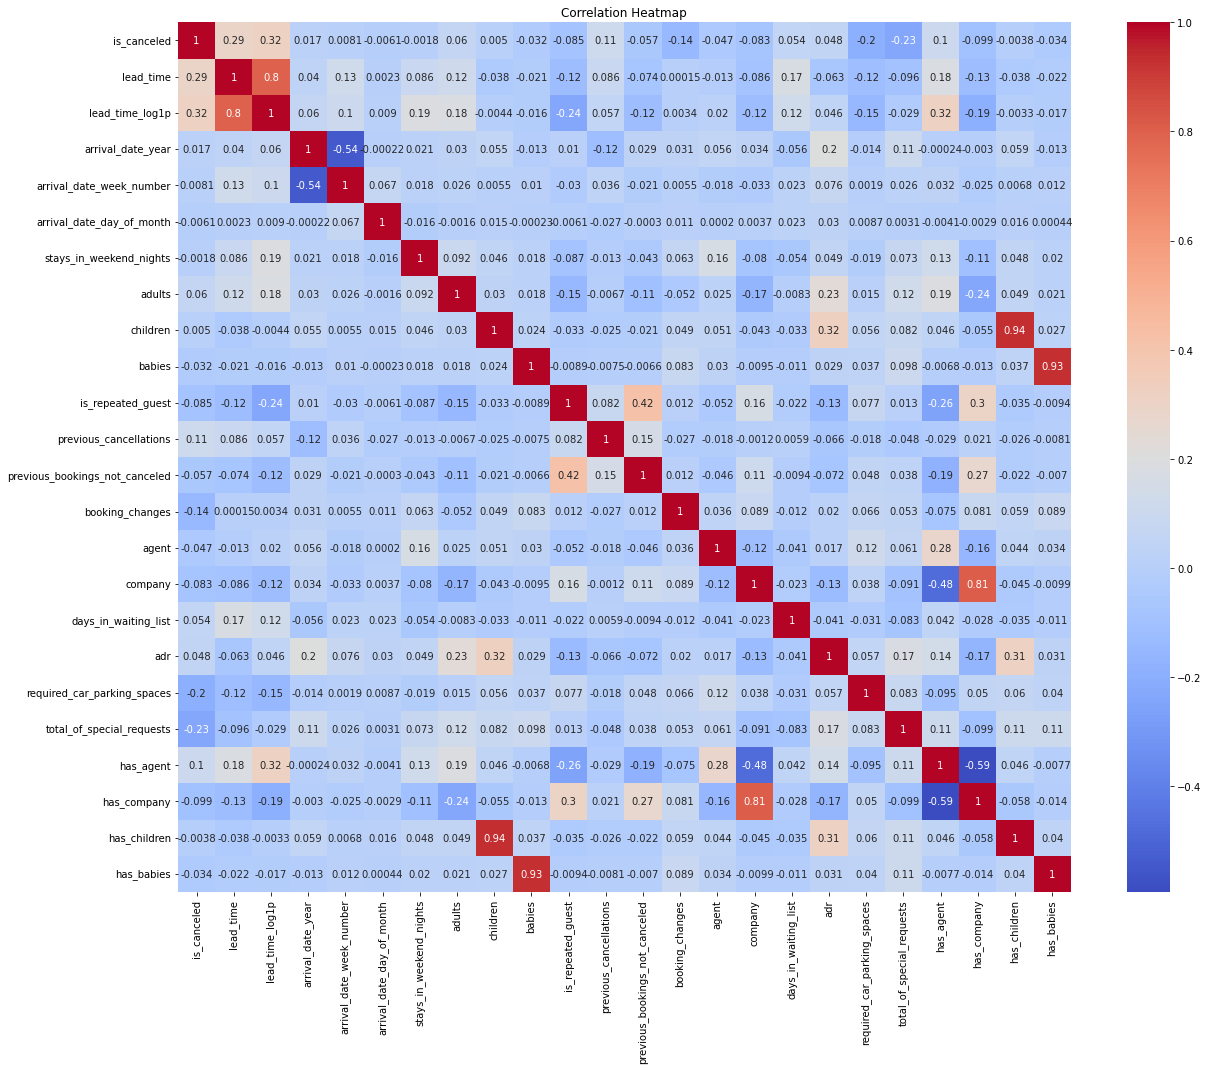

In [14]:
# Do a correlation heatmap to look for highly correlated data that could cause regression problems
# It can also provide clues as to which variables predict is_canceled
df_numerical = df[numeric_columns]

# Compute the correlation matrix
correlation_matrix = df_numerical.corr()

# Generate the correlation heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Customize the plot
plt.title('Correlation Heatmap')
plt.show()


Text(0.5, 1.0, 'Histogram Bivariate Distribution Plot')

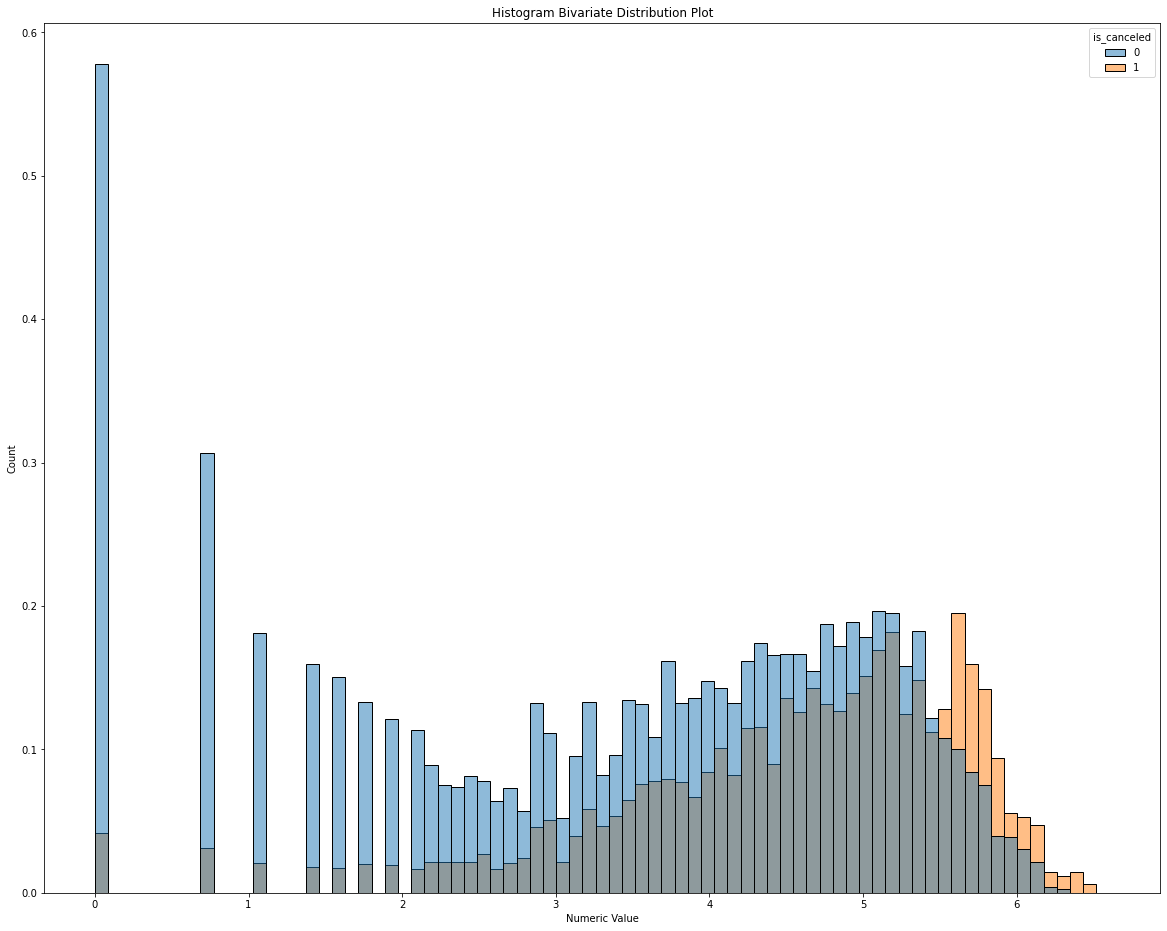

In [15]:
sns.histplot(data=df, x='lead_time_log1p', hue='is_canceled', kde=False, stat='density')

# Set the labels and title
plt.xlabel('Numeric Value')
plt.ylabel('Count')
plt.title('Histogram Bivariate Distribution Plot')

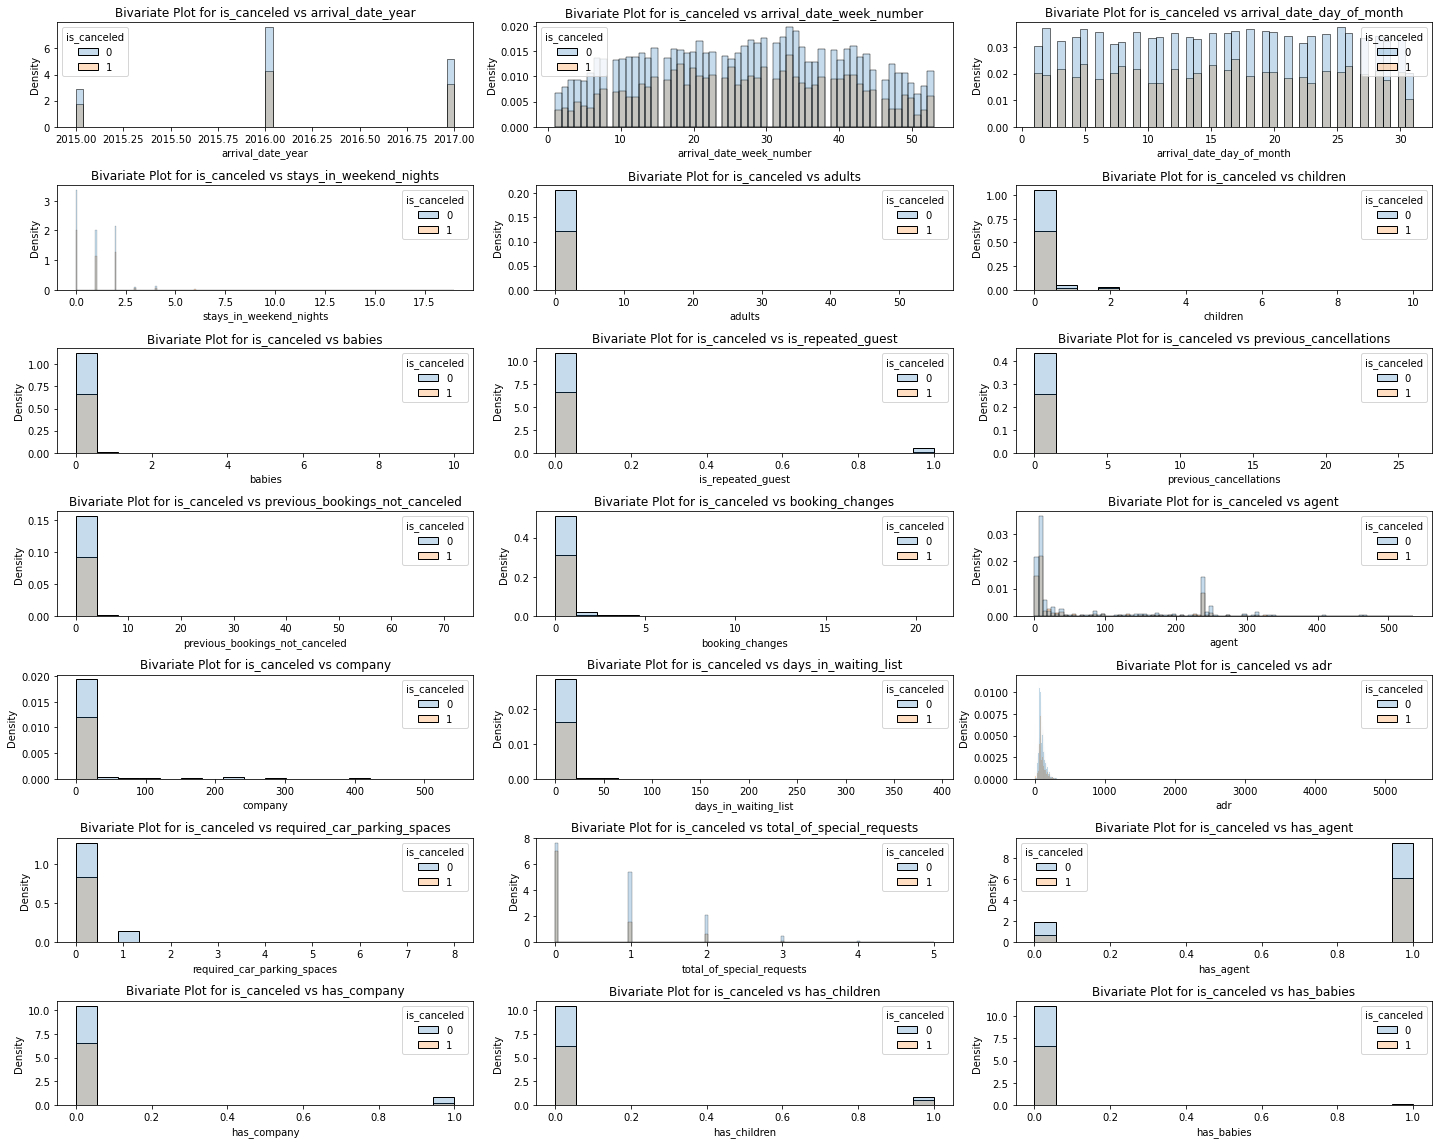

In [16]:
# Get a list of column names (excluding the 'is_canceled' column)
plot_columns = numeric_columns[3:]


# Calculate the number of rows and columns for the subplot grid
num_cols = 3 
num_rows = len(plot_columns) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols)
fig.subplots_adjust(hspace=0.525, wspace=0.4) # needed for whitespace between plots

# Create the bivariate subplots using Seaborn
for i, column in enumerate(plot_columns):
   
    ax = sns.histplot(data=df, alpha = 0.25, x=column, hue='is_canceled', kde=False, stat='density', ax=axes[i // num_cols, i % num_cols])
    ax.set(title=f'Bivariate Plot for is_canceled vs {column}')
    

plt.tight_layout()  # To avoid overlapping of subplots
plt.show()

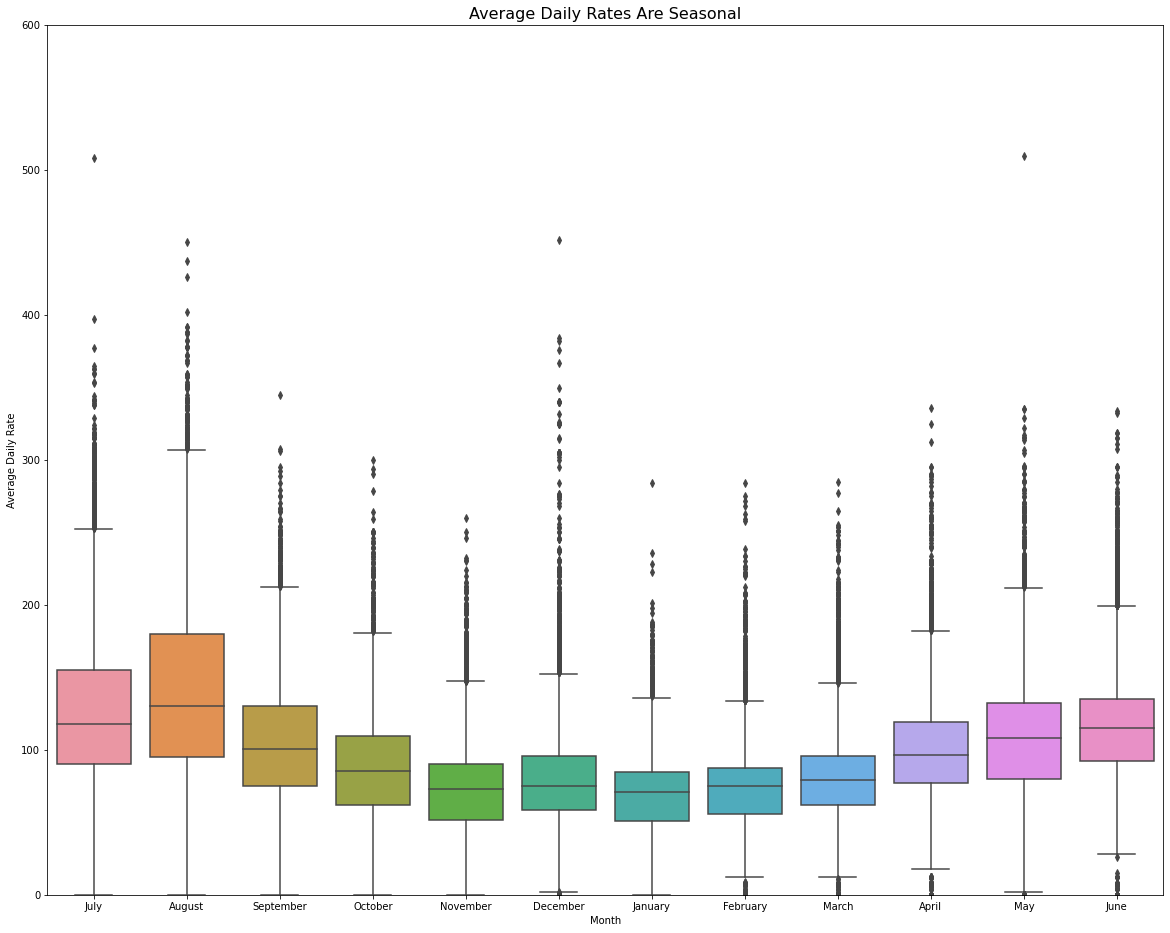

In [17]:
# Generate the boxplot using seaborn
ax = sns.boxplot(x='arrival_date_month', y='adr', data=df)
#ax.set_yscale('log')
ax.set_ylim(0, 600)

# Customize the plot
plt.title('Average Daily Rates Are Seasonal', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Daily Rate')
plt.show()


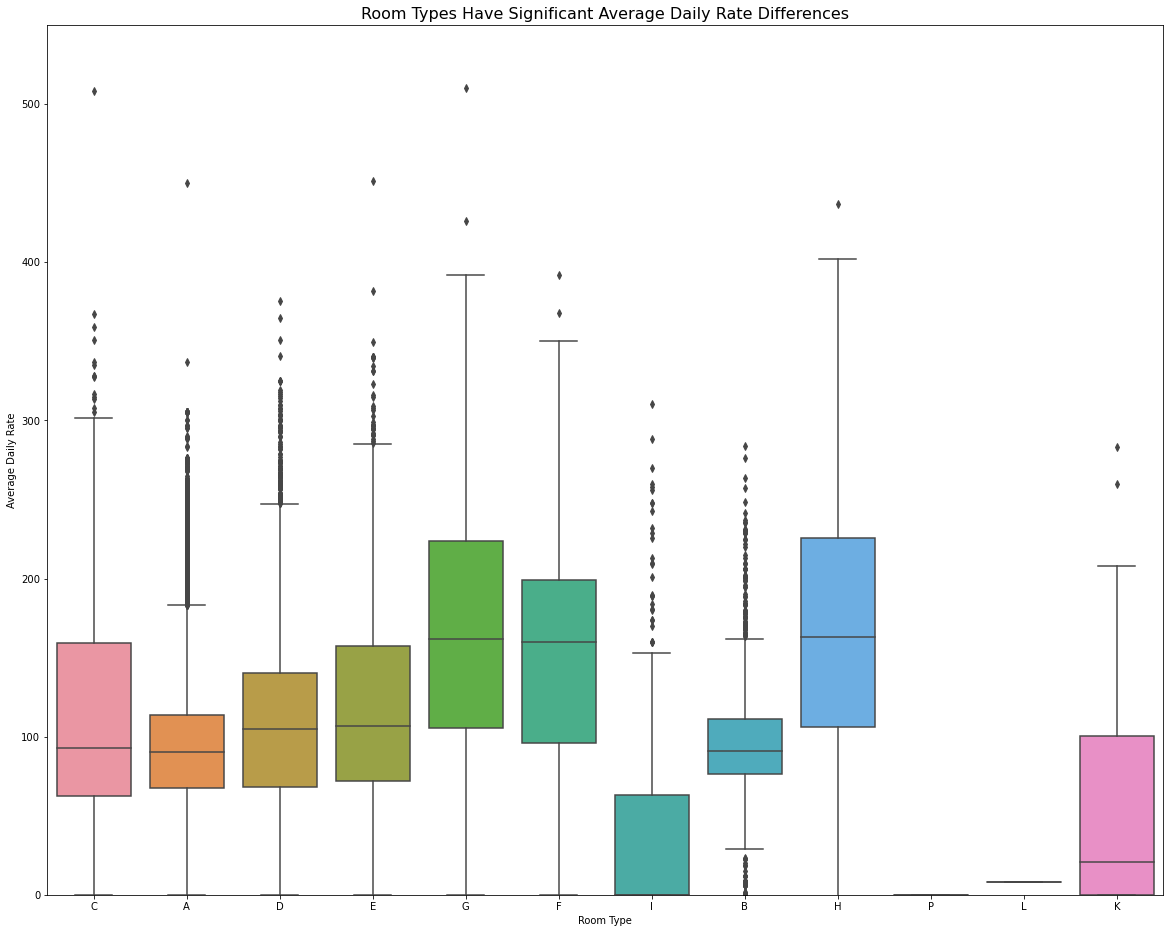

In [18]:
# Generate the boxplot using seaborn
ax = sns.boxplot(x='assigned_room_type', y='adr', data=df)
#ax.set_yscale('log')
ax.set_ylim(0, 550)

# Customize the plot
plt.title('Room Types Have Significant Average Daily Rate Differences', fontsize=16)
plt.xlabel('Room Type')
plt.ylabel('Average Daily Rate')
plt.show()


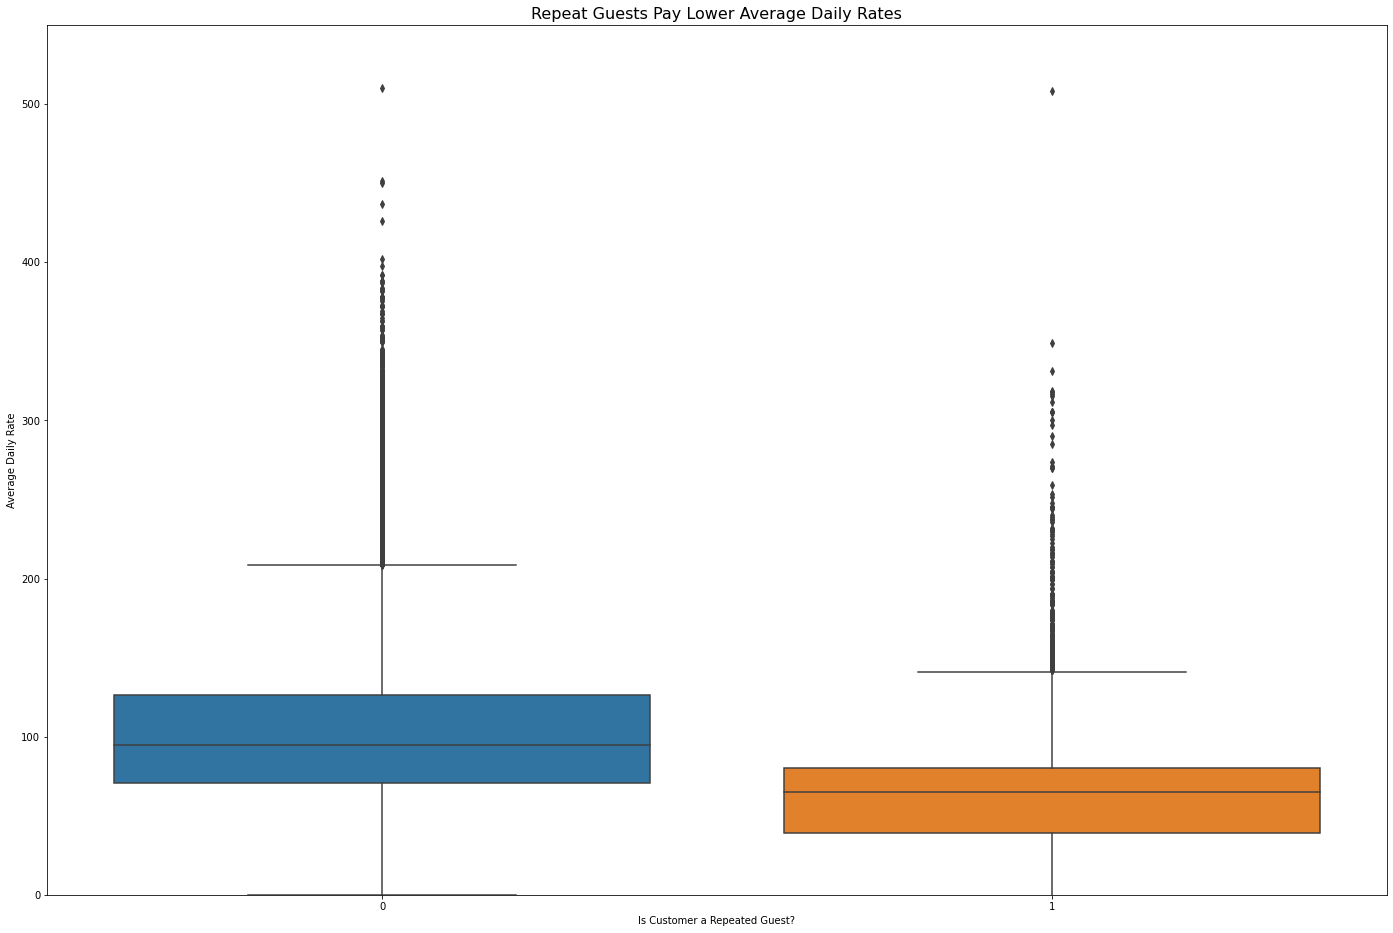

In [19]:
# Generate the boxplot using seaborn
plt.rcParams['figure.figsize'] = [24, 16]
ax = sns.boxplot(x='is_repeated_guest', y='adr', data=df)
#ax.set_yscale('log')
ax.set_ylim(0, 550)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Customize the plot
plt.title('Repeat Guests Pay Lower Average Daily Rates', fontsize=16)
plt.xlabel('Is Customer a Repeated Guest?')
plt.ylabel('Average Daily Rate')
plt.show()


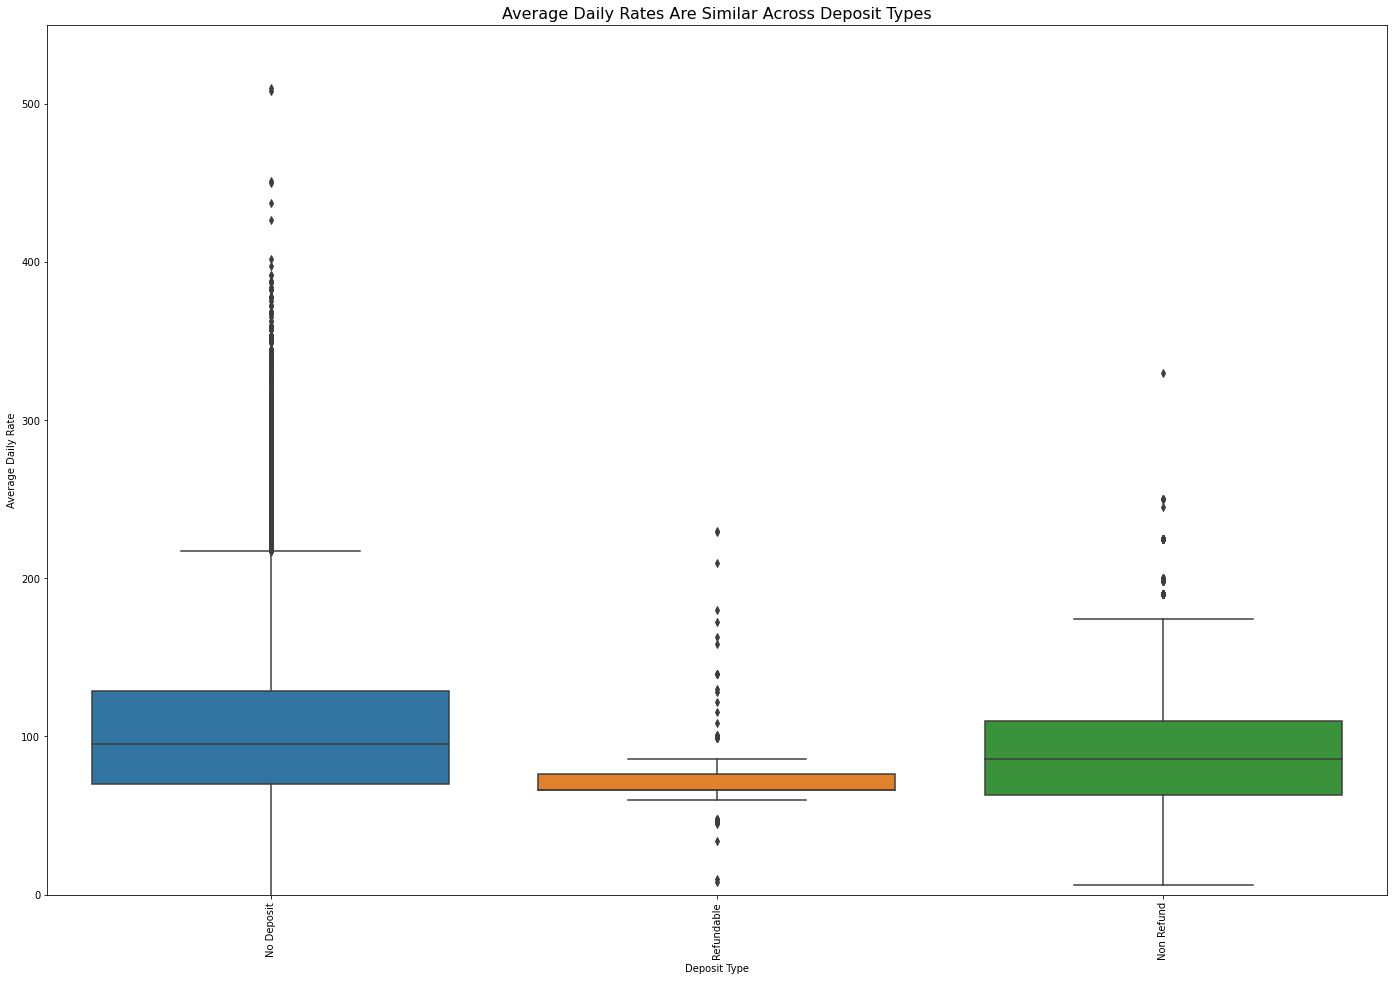

In [20]:
# Generate the boxplot using seaborn
plt.rcParams['figure.figsize'] = [24, 16]
ax = sns.boxplot(x='deposit_type', y='adr', data=df)
#ax.set_yscale('log')
ax.set_ylim(0, 550)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Customize the plot
plt.title('Average Daily Rates Are Similar Across Deposit Types', fontsize=16)
plt.xlabel('Deposit Type')
plt.ylabel('Average Daily Rate')
plt.show()


### ANOVA Analysis Grouped by is_canceled

In [21]:
formula = 'is_canceled ~ arrival_date_month + booking_changes + country + customer_type + deposit_type + distribution_channel + is_repeated_guest + market_segment + meal + reserved_room_type + has_agent + has_company + has_children + has_babies'
model = sm.formula.ols(formula,data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                            sum_sq        df            F         PR(>F)
arrival_date_month       88.526834      11.0    52.108848  1.467621e-115
country                1630.838226     177.0    59.657746   0.000000e+00
customer_type            52.317152       3.0   112.915111   5.179361e-73
deposit_type           2018.886281       2.0  6535.985561   0.000000e+00
distribution_channel     10.673845       4.0    17.277867   3.528990e-14
market_segment          395.440498       7.0   365.773575   0.000000e+00
meal                     31.369759       4.0    50.778563   8.751435e-43
reserved_room_type       28.736823       9.0    20.674045   2.927160e-35
booking_changes         109.033169       1.0   705.972617  4.270900e-155
is_repeated_guest        63.762457       1.0   412.851879   1.256144e-91
has_agent                30.285927       1.0   196.096613   1.610768e-44
has_company               3.590474       1.0    23.247754   1.425919e-06
has_children              8.940124       1.0    57.

### What does this ANOVA analysis mean?
The p-values of this ANOVA analysis (last column) are all greater than 0.05. That means there is a statistical significant at the 95% confidence interval that at least some of the category values within these categories have statistically different means. Thus, we should evaluate all of them in our prediction model.

In [22]:
# before we can do logistical regression, the categorical variables must be converted to 
# numeric value using the process of one-hot encoding.

def one_hot_encode_dataframe(df):
    # Create a copy of the DataFrame
    df_encoded = df.copy()

    # Identify columns of type "object"
    object_columns = df_encoded.select_dtypes(include=['object']).columns

    # One-hot encode columns of type "object" with drop_first=True
    df_encoded = pd.get_dummies(df_encoded, columns=object_columns, drop_first=True)

    return df_encoded


## Predictive Modeling for Cancellations

### Description of Algorithm for Selecting Variables in Logistic Regression Model

The algorithm for selecting variables in the Logistic Regression model follows a stepwise approach to find the most influential predictors based on the AIC fit metric.

1. **Step 1: Initial Selection:** Add variables one at a time, evaluating their individual impact on the AIC score. Retain the variable with the lowest AIC, considering it as the initial selection.

2. **Step 2: Pairwise Evaluation:** Pair the initial selected variable with each of the remaining variables. Choose the variable that results in the lowest AIC when combined with the initial selection. Continue this process iteratively to include more variables until no further improvement in the AIC value is observed.

3. **Step 3: Quality Control:** After the initial variable selection, check each variable's p-value. Remove variables with p-values ≥ 0.05, starting with the highest p-value first. Perform this process iteratively until all remaining variables have p-values < 0.05.

Please note that the algorithm may slow down with a large number of variables. To manage this, we will conduct the selection process in two batches. First, we will consider all variables except for the country codes, and then we will perform a second batch analysis with just the country codes. After pruning both lists, we will concatenate them and manually review the variables for a final selection.

### Variables to be Eliminated

The following variables will be eliminated immediately:

- `reservation_status_date`: Removed due to its date format, leading to too many categories.
- `reservation_status`: Excluded as it contains a redundant category value of `is_canceled`.
- `assigned_room_type`: Excluded because it is not known until the customer shows up, making it unsuitable for prediction.
- `agent` and `company`: Removed due to their numerous ID values. Instead, we will use `has_agent` and `has_company`.
- `lead_time`: Dropped in favor of `lead_time_log1p`.
- `deposit_type`: Likely a value created by the hotel, making it unnecessary for prediction.

### Handling Singular Matrix Exception

If the algorithm encounters a singular matrix exception during the SVD algorithm, the triggering variable will be added to a list of variables to be excluded before rerunning the selection process.


In [23]:
# Split the data into training and test sets
df_subset = df.drop(['reservation_status_date','reservation_status','assigned_room_type',
                    'agent','company','lead_time','deposit_type'], axis=1)
# batch one will leave out country codes for a second batch to make things run faster
df_first_batch = df_subset.drop(['country'], axis=1)
#'country','required_car_parking_spaces'

# do the one-hot-encoding
encoded_data = one_hot_encode_dataframe(df_first_batch)

X = encoded_data.drop(['is_canceled'], axis=1)
y = encoded_data['is_canceled']

# set random_state to 42 so we can reproduce this splitting later for the second batch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
# This function is responsible for select the variables one at a time to include in the model
def stepwise_selection(X, y, verbose=True):
    included = []
    best_aic = float('inf')
    excluded = list(X.columns)
    
    while len(excluded) > 0:
        new_aic = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            if verbose:
                print(f"trying {new_column}")
            np.random.seed(42)  # Set the seed before each model fitting
            try:
                #model = sm.Logit(y, sm.add_constant(X[included + [new_column]])).fit(disp=False)
                model = sm.Logit(y, sm.add_constant(X[included + [new_column]])).fit(disp=False, method='bfgs',maxiter=100)
                new_aic[new_column] = model.aic
            except np.linalg.LinAlgError:
                new_aic[new_column] = float('inf')
                if verbose:
                    print(f"Variable {new_column} rejected: Singular Matrix Exception")
                excluded.remove(new_column)
        
        current_aic = new_aic.min()  # Store the AIC value during the loop iteration
        print(f'Current list {included}, best variable {new_aic.idxmin()}')
        print(f'Current aic {current_aic}, best aic {best_aic}')
        
        if current_aic < best_aic:  # Compare the current AIC with the previous best AIC
            best_feature = new_aic.idxmin()
            try:
                np.random.seed(42)  # Set the seed before each model fitting
                #model = sm.Logit(y, sm.add_constant(X[included + [best_feature]])).fit(disp=False)
                model = sm.Logit(y, sm.add_constant(X[included + [best_feature]])).fit(disp=False, method='bfgs',maxiter=100)
                if model.pvalues[best_feature] < 0.05:
                    if verbose:
                        print(f"{included} {best_feature}")
                        print(f"Best feature: {best_feature}  AIC = {current_aic}  p-value = {model.pvalues[best_feature]}")
                    included.append(best_feature)
                else:
                    if verbose:
                        print(f"Best feature {best_feature} rejected: p-value = {model.pvalues[best_feature]}")
                excluded.remove(best_feature)
                best_aic = current_aic  # Update the best_aic with the current_aic value
            except np.linalg.LinAlgError:
                if verbose:
                    print(f"Variable {best_feature} rejected: Singular Matrix Exception")
                excluded.remove(best_feature)
        else:
            break

        if not included:
            if verbose:
                print("No variable can be added. Exiting...")
            break
    
    print('Exiting')
    return included

In [25]:
variables_to_exclude = ['distribution_channel_Undefined','market_segment_Undefined','required_car_parking_spaces']
selected_features = stepwise_selection(X_train.drop(variables_to_exclude,axis=1), y_train)

trying arrival_date_year
trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying previous_cancellations
trying previous_bookings_not_canceled
trying booking_changes
trying days_in_waiting_list
trying adr
trying total_of_special_requests


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying lead_time_log1p
trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Groups
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying re

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying previous_cancellations
trying previous_bookings_not_canceled
trying booking_changes
trying days_in_waiting_list
trying adr
trying total_of_special_requests


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Groups
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
tryi

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying previous_cancellations
trying previous_bookings_not_canceled
trying booking_changes
trying days_in_waiting_list
trying adr


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Groups
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
tryi

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying previous_cancellations
trying previous_bookings_not_canceled
trying booking_changes
trying days_in_waiting_list
trying adr
trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Groups
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
trying reserved_room_

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying previous_bookings_not_canceled
trying booking_changes
trying days_in_waiting_list
trying adr
trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Groups
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
trying reserved_room_

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying booking_changes
trying days_in_waiting_list
trying adr


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Groups
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
tryi

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying booking_changes
trying days_in_waiting_list
trying adr


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
trying reserved_room_type_H
tryin

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying days_in_waiting_list
trying adr


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Offline TA/TO
trying market_segment_Online TA
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
trying reserved_room_type_H
tryin

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number
trying arrival_date_day_of_month
trying stays_in_weekend_nights
trying stays_in_week_nights
trying adults
trying children
trying babies
trying is_repeated_guest
trying days_in_waiting_list
trying adr


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent
trying has_company
trying has_children
trying has_babies
trying hotel_Resort Hotel
trying arrival_date_month_August
trying arrival_date_month_December
trying arrival_date_month_February
trying arrival_date_month_January
trying arrival_date_month_July
trying arrival_date_month_June
trying arrival_date_month_March
trying arrival_date_month_May
trying arrival_date_month_November
trying arrival_date_month_October
trying arrival_date_month_September
trying meal_FB
trying meal_HB
trying meal_SC
trying meal_Undefined
trying market_segment_Complementary
trying market_segment_Corporate
trying market_segment_Direct
trying market_segment_Offline TA/TO
trying distribution_channel_Direct
trying distribution_channel_GDS
trying distribution_channel_TA/TO
trying reserved_room_type_B
trying reserved_room_type_C
trying reserved_room_type_D
trying reserved_room_type_E
trying reserved_room_type_F
trying reserved_room_type_G
trying reserved_room_type_H
trying reserved_room_type_L
trying re

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA'] adr
Best feature: adr  AIC = 93358.8674955638  p-value = 1.0980399101569469e-95
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying hotel_Resort Hotel


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_July


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Corporate


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_D


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr'], best variable distribution_channel_Direct
Current aic 92979.7572795712, best aic 93358.8674955638


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr'] distribution_channel_Direct
Best feature: distribution_channel_Direct  AIC = 92979.7572795712  p-value = 1.1088376236690003e-81
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying hotel_Resort Hotel


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_July


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Corporate


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_D


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct'], best variable hotel_Resort Hotel
Current aic 92763.5012939354, best aic 92979.7572795712


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct'] hotel_Resort Hotel
Best feature: hotel_Resort Hotel  AIC = 92763.5012939354  p-value = 4.1210065546638465e-49
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_week_number
trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_July


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Corporate


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_D


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying customer_type_Group
trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel'], best variable arrival_date_month_July
Current aic 92631.9936729664, best aic 92763.5012939354


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel'] arrival_date_month_July
Best feature: arrival_date_month_July  AIC = 92631.9936729664  p-value = 1.864173404236051e-30
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_week_number
trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Corporate


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_D


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_P
trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July'], best variable reserved_room_type_D
Current aic 92508.77105268085, best aic 92631.9936729664


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July'] reserved_room_type_D
Best feature: reserved_room_type_D  AIC = 92508.77105268085  p-value = 1.027955350133392e-28
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_week_number
trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_agent


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Corporate


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group
trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D'], best variable has_agent
Current aic 92414.9204363659, best aic 92508.77105268085


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D'] has_agent
Best feature: has_agent  AIC = 92414.9204363659  p-value = 9.137682760045501e-23
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_company


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying market_segment_Corporate
trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying distribution_channel_TA/TO
trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party
Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent'], best variable has_company
Current aic 92247.04185283431, best aic 92414.9204363659


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent'] has_company
Best feature: has_company  AIC = 92247.04185283431  p-value = 1.3794071670099124e-37
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list
trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_month_August
trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_month_June
trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying meal_HB
trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Corporate
trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO
trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_C
trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_G
trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company'], best variable market_segment_Corporate
Current aic 92092.62256208865, best aic 92247.04185283431
['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company'] market_segment_Corporate
Best feature: market_segment_Corporate  AIC = 92092.62256208865  p-value = 1.3234466400492078e-36
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies
trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May
trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB
trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_Undefined


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C
trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate'], best variable meal_Undefined
Current aic 92021.67512184827, best aic 92092.62256208865


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate'] meal_Undefined
Best feature: meal_Undefined  AIC = 92021.67512184827  p-value = 5.840087782537374e-16
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_February


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B
trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.

trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined'], best variable arrival_date_month_February
Current aic 91947.05902307543, best aic 92021.67512184827


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined'] arrival_date_month_February
Best feature: arrival_date_month_February  AIC = 91947.05902307543  p-value = 6.552653605193746e-19
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_January


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February'], best variable arrival_date_month_January
Current aic 91887.08557182731, best aic 91947.05902307543


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February'] arrival_date_month_January
Best feature: arrival_date_month_January  AIC = 91887.08557182731  p-value = 3.2702740242847047e-16
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_F


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January'], best variable reserved_room_type_F
Current aic 91827.86968066535, best aic 91887.08557182731


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January'] reserved_room_type_F
Best feature: reserved_room_type_F  AIC = 91827.86968066535  p-value = 1.0660015307072275e-14
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Transient-Party


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F'], best variable customer_type_Transient-Party
Current aic 91766.1203298955, best aic 91827.86968066535


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F'] customer_type_Transient-Party
Best feature: customer_type_Transient-Party  AIC = 91766.1203298955  p-value = 1.380492339574191e-17
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_August


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party'], best variable arrival_date_month_August
Current aic 91711.57435816, best aic 91766.1203298955


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party'] arrival_date_month_August
Best feature: arrival_date_month_August  AIC = 91711.57435816  p-value = 8.741770407986462e-14
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_HB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August'], best variable meal_HB
Current aic 91657.8240052703, best aic 91711.57435816


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August'] meal_HB
Best feature: meal_HB  AIC = 91657.8240052703  p-value = 1.5449243655796164e-13
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_December


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB'], best variable arrival_date_month_December
Current aic 91611.04988130032, best aic 91657.8240052703


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB'] arrival_date_month_December
Best feature: arrival_date_month_December  AIC = 91611.04988130032  p-value = 2.0691354067978583e-12
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Complementary


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December'], best variable market_segment_Complementary
Current aic 91566.00766742541, best aic 91611.04988130032


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December'] market_segment_Complementary
Best feature: market_segment_Complementary  AIC = 91566.00766742541  p-value = 4.343241437432429e-06
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying is_repeated_guest


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary'], best variable is_repeated_guest
Current aic 91530.46375713222, best aic 91566.00766742541


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary'] is_repeated_guest
Best feature: is_repeated_guest  AIC = 91530.46375713222  p-value = 1.1877778173146082e-09
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_September


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest'], best variable arrival_date_month_September
Current aic 91496.20641604098, best aic 91530.46375713222


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest'] arrival_date_month_September
Best feature: arrival_date_month_September  AIC = 91496.20641604098  p-value = 4.205831705362421e-08
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_G


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September'], best variable reserved_room_type_G
Current aic 91461.22329441523, best aic 91496.20641604098


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September'] reserved_room_type_G
Best feature: reserved_room_type_G  AIC = 91461.22329441523  p-value = 6.130337962481054e-09
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_E


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G'], best variable reserved_room_type_E
Current aic 91432.61911904553, best aic 91461.22329441523


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G'] reserved_room_type_E
Best feature: reserved_room_type_E  AIC = 91432.61911904553  p-value = 6.486248717734953e-08
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_GDS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E'], best variable distribution_channel_GDS
Current aic 91406.27636740696, best aic 91432.61911904553


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E'] distribution_channel_GDS
Best feature: distribution_channel_GDS  AIC = 91406.27636740696  p-value = 0.0006062855231898349
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_May


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS'], best variable arrival_date_month_May
Current aic 91384.4799376091, best aic 91406.27636740696


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS'] arrival_date_month_May
Best feature: arrival_date_month_May  AIC = 91384.4799376091  p-value = 4.9358991518721776e-06
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_June


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May'], best variable arrival_date_month_June
Current aic 91370.5810310897, best aic 91384.4799376091


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May'] arrival_date_month_June
Best feature: arrival_date_month_June  AIC = 91370.5810310897  p-value = 0.0005244104223959943
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_H


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June'], best variable reserved_room_type_H
Current aic 91357.12209841986, best aic 91370.5810310897


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June'] reserved_room_type_H
Best feature: reserved_room_type_H  AIC = 91357.12209841986  p-value = 0.0003438532210515727
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying days_in_waiting_list


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H'], best variable days_in_waiting_list
Current aic 91345.86581911505, best aic 91357.12209841986


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H'] days_in_waiting_list
Best feature: days_in_waiting_list  AIC = 91345.86581911505  p-value = 0.00024106812247847432
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_B


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list'], best variable reserved_room_type_B
Current aic 91336.1493647283, best aic 91345.86581911505


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list'] reserved_room_type_B
Best feature: reserved_room_type_B  AIC = 91336.1493647283  p-value = 0.0004175583558073529
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B'], best variable has_babies
Current aic 91328.48496990732, best aic 91336.1493647283


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B'] has_babies
Best feature: has_babies  AIC = 91328.48496990732  p-value = 0.0011276470761106827
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_day_of_month


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies'], best variable arrival_date_day_of_month
Current aic 91320.74964482077, best aic 91328.48496990732


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies'] arrival_date_day_of_month
Best feature: arrival_date_day_of_month  AIC = 91320.74964482077  p-value = 0.01278265508280

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_FB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies', 'arrival_date_day_of_month'], best variable meal_FB
Current aic 91316.39199871177, best aic 91320.7496448

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies', 'arrival_date_day_of_month'] meal_FB
Best feature: meal_FB  AIC = 91316.39199871177  p-value = 0.0059239003018020965
t

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_P


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies', 'arrival_date_day_of_month', 'meal_FB'], best variable reserved_room_type_P
Current aic 91312.22900406335

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Best feature reserved_room_type_P rejected: p-value = 0.7678808095444297
trying arrival_date_year


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_week_number


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_weekend_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying stays_in_week_nights


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying adults


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying babies


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying has_children


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_March


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_November


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying arrival_date_month_October


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying meal_SC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Direct


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying market_segment_Offline TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying distribution_channel_TA/TO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_C


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying reserved_room_type_L


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


trying customer_type_Group
Current list ['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies', 'arrival_date_day_of_month', 'meal_FB'], best variable arrival_date_year
Curre

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
print(selected_features)
print(len(selected_features))

['lead_time_log1p', 'total_of_special_requests', 'customer_type_Transient', 'previous_cancellations', 'previous_bookings_not_canceled', 'market_segment_Groups', 'booking_changes', 'market_segment_Online TA', 'adr', 'distribution_channel_Direct', 'hotel_Resort Hotel', 'arrival_date_month_July', 'reserved_room_type_D', 'has_agent', 'has_company', 'market_segment_Corporate', 'meal_Undefined', 'arrival_date_month_February', 'arrival_date_month_January', 'reserved_room_type_F', 'customer_type_Transient-Party', 'arrival_date_month_August', 'meal_HB', 'arrival_date_month_December', 'market_segment_Complementary', 'is_repeated_guest', 'arrival_date_month_September', 'reserved_room_type_G', 'reserved_room_type_E', 'distribution_channel_GDS', 'arrival_date_month_May', 'arrival_date_month_June', 'reserved_room_type_H', 'days_in_waiting_list', 'reserved_room_type_B', 'has_babies', 'arrival_date_day_of_month', 'meal_FB']
38


In [27]:
# Evaluate the quality of the model by a confusion matrix and
# getting the p-values for the coefficients
# Fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train[selected_features]))
result = logit_model.fit()

# Make predictions on the trainig data set
y_pred = result.predict(sm.add_constant(X_train[selected_features]))
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
confusion = confusion_matrix(y_train, y_pred_binary)
classification = classification_report(y_train, y_pred_binary)
auc = roc_auc_score(y_train, y_pred)

# Print the evaluation results
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)
print("\nAUC Score: ", auc)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.477522
         Iterations 9
Confusion Matrix:
[[53437  6696]
 [13333 22046]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     60133
           1       0.77      0.62      0.69     35379

    accuracy                           0.79     95512
   macro avg       0.78      0.76      0.76     95512
weighted avg       0.79      0.79      0.78     95512


AUC Score:  0.832942921669999
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                95512
Model:                          Logit   Df Residuals:                    95473
Method:                           MLE   Df Model:                           38
Date:                Fri, 21 Jul 2023   Pseudo R-squ.:                  0.2756
Time:                        01:48:28   Log-Likelihood:                -

### Interpreting the Quality of Model Fit

The classification report indicates that, on the training data, the model was correct 80% of the time when predicting non-cancellations, capturing 89% of all non-cancellations. For cancellations, the model achieved 77% accuracy and identified 62% of all cancellations.

Please note that the AUC score (0.8329) represents the area under the Receiver Operating Characteristic (ROC) curve, indicating good discriminative power of the model.

Nevetheless, I choose to prune the model further because the last two variables have p-values an order of magnitude larger than all the others. In addition, there is no obvious domain explanation why the arrival day of the month should matter instead of being just a random coincidence. With this many variables (i.e., well over 100 including the counties) to consider and only using a 95% confidence interval, there is a signficant chance that some will randomly pass the 95% criteria. Thus, I will make it a 98% confidence interval criteria.  

In [28]:
# Evaluate the quality of the model by a confusion matrix and
# getting the p-values for the coefficients
# Fit the logistic regression model minus the last two features
subset_features = selected_features[:-2]
logit_model = sm.Logit(y_train, sm.add_constant(X_train[subset_features]))
result = logit_model.fit()

# Make predictions on the training dataset
y_pred = result.predict(sm.add_constant(X_train[subset_features]))

y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
confusion = confusion_matrix(y_train, y_pred_binary)
classification = classification_report(y_train, y_pred_binary)
auc = roc_auc_score(y_train, y_pred)

# Print the evaluation results
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)
print("\nAUC Score: ", auc)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.477587
         Iterations 9
Confusion Matrix:
[[53409  6724]
 [13395 21984]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     60133
           1       0.77      0.62      0.69     35379

    accuracy                           0.79     95512
   macro avg       0.78      0.75      0.76     95512
weighted avg       0.79      0.79      0.78     95512


AUC Score:  0.8328680015336346
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                95512
Model:                          Logit   Df Residuals:                    95475
Method:                           MLE   Df Model:                           36
Date:                Fri, 21 Jul 2023   Pseudo R-squ.:                  0.2755
Time:                        01:48:28   Log-Likelihood:                

Note how removing those two variables did not impact the F scores to two decimal places.

In [29]:
# Now let's select which countries should be in the model
encoded_data_country = df[['country','is_canceled']]
encoded_data_country = one_hot_encode_dataframe(encoded_data_country)

X = encoded_data_country.drop(['is_canceled'], axis=1)
y = encoded_data_country['is_canceled']

# set random_state to 42 to match the splitting for the first batch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

countries_to_exclude = []
selected_countries = stepwise_selection(X_train.drop(countries_to_exclude,axis=1), y_train)

trying country_AGO
trying country_AIA
trying country_ALB
trying country_AND
trying country_ARE
trying country_ARG
trying country_ARM
trying country_ASM
trying country_ATA
trying country_ATF
trying country_AUS
trying country_AUT
trying country_AZE
trying country_BDI
trying country_BEL
trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRA
trying country_BRB
trying country_BWA
trying country_CAF
trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CHL
trying country_CHN
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DEU
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY
trying country_HKG
trying country_HND
trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_ITA
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR
trying country_KNA
trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA
trying country_LIE
trying country_LKA
trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRT
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying country_STP
trying country_SUR
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEN
trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRA
trying country_BRB
trying country_BWA
trying country_CAF
trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CHL
trying country_CHN
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DEU
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG
trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_ITA
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR
trying country_KNA
trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA
trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LKA
trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying country_STP
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRA
trying country_BRB
trying country_BWA
trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CHE
trying country_CHL
trying country_CHN
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DEU
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY
trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR
trying country_KNA
trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA
trying country_LIE
trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying country_STP
trying country_SUR
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL
trying country_BEN
trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRA
trying country_BRB
trying country_BWA
trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CHE
trying country_CHL
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DEU
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG
trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR
trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KOR
trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA
trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LKA
trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying country_STP
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEN
trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE
trying country_CHL
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DEU
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG
trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR
trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KOR
trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA
trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LKA
trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying country_STP
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL
trying country_BEN
trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE
trying country_CHL
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DEU
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG
trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KNA
trying country_KOR
trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LIE
trying country_LKA
trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL
trying country_BEN
trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE
trying country_CHL
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRA
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG
trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KNA
trying country_KOR
trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LIE
trying country_LKA
trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL
trying country_BEN
trying country_BFA
trying country_BGD
trying country_BGR
trying country_BHR
trying country_BHS
trying country_BIH
trying country_BLR
trying country_BOL
trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE
trying country_CHL
trying country_CIV
trying country_CMR
trying country_CN
trying country_COL
trying country_COM
trying country_CPV
trying country_CRI
trying country_CUB
trying country_CYM
trying country_CYP
trying country_CZE
trying country_DJI
trying country_DMA
trying country_DNK
trying country_DOM
trying country_DZA
trying country_ECU
trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN
trying country_FJI
trying country_FRO
trying country_GAB
trying country_GBR
trying country_GEO
trying country_GGY
trying country_GHA
trying country_GIB
trying country_GLP
trying country_GNB
trying country_GRC
trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG
trying country_HND
trying country_HRV
trying country_HUN
trying country_IDN
trying country_IMN
trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ
trying country_ISL
trying country_ISR
trying country_JAM
trying country_JEY
trying country_JOR
trying country_JPN
trying country_KAZ
trying country_KEN
trying country_KHM
trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KNA
trying country_KOR
trying country_KWT
trying country_LAO
trying country_LBN
trying country_LBY
trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LIE
trying country_LKA
trying country_LTU
trying country_LUX
trying country_LVA
trying country_MAC
trying country_MAR
trying country_MCO
trying country_MDG
trying country_MDV
trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT
trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS
trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA
trying country_NIC
trying country_NLD
trying country_NOR
trying country_NPL
trying country_NZL
trying country_OMN
trying country_PAK
trying country_PAN
trying country_PER
trying country_PHL
trying country_PLW
trying country_POL
trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT
trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN
trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB
trying count

/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM
trying country_ASM
trying country_ATA
trying country_ATF
trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT
trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL
trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA
trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR
trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS
trying country_BIH
trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE
trying country_CHL
trying country_CIV
trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN
trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM
trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM
trying country_CYP
trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI
trying country_DMA
trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA
trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY
trying country_ESP
trying country_EST
trying country_ETH
trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI
trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB
trying country_GBR
trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY
trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB
trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND
trying country_HRV
trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND
trying country_IRL
trying country_IRN
trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR
trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ
trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KNA
trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO
trying country_LBN
trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LIE
trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO
trying country_MDG
trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR
trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC
trying country_NLD
trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL
trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN
trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER
trying country_PHL
trying country_PLW
trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU
trying country_RUS
trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP
trying country_SUR
trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN
trying country_SWE
trying country_SYC
trying country_SYR
trying country_TGO
trying country_THA
trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP
trying country_TUN
trying country_TUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN
trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA
trying country_UKR
trying country_UMI
trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY
trying country_USA
trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB
trying country_VNM
trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB
trying country_ZWE
Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE'], best variable country_GBR
Current aic 113898.20215735605, best aic 113956.7737806305
['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE'] country_GBR
Best feature: country_GBR  AIC = 113898.20215735605  p-value = 1.429255595369587e-14
trying country_AIA
trying country_ALB
trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM
trying country_ASM
trying country_ATA
trying country_ATF
trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA
trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR
trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS
trying country_BIH
trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL
trying country_CIV
trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM
trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM
trying country_CYP
trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI
trying country_DMA
trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU
trying country_EGY
trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST
trying country_ETH
trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI
trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB
trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY
trying country_GHA
trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB
trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND
trying country_HRV
trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND
trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN
trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR
trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR
trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ
trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KNA
trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO
trying country_LBN
trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LIE
trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO
trying country_MDG
trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC
trying country_NLD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL
trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN
trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER
trying country_PHL
trying country_PLW
trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA
trying country_SAU
trying country_SDN
trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP
trying country_SUR
trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN
trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC
trying country_SYR
trying country_TGO
trying country_THA
trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP
trying country_TUN
trying country_TUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN
trying country_TZA
trying country_UGA
trying country_UKR
trying country_UMI
trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY
trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB
trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB
trying country_VNM
trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB
trying country_ZWE
Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR'], best variable country_SAU
Current aic 113861.15783646906, best aic 113898.20215735605
['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR'] country_SAU
Best feature: country_SAU  AIC = 113861.15783646906  p-value = 5.8416787712631504e-09
trying country_AIA
trying country_ALB
trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM
trying country_ASM
trying country_ATA
trying country_ATF
trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA
trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR
trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS
trying country_BIH
trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB
trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_CAF
trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL
trying country_CIV
trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM
trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM
trying country_CYP
trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI
trying country_DMA
trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY
trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST
trying country_ETH
trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI
trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB
trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY
trying country_GHA
trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB
trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM
trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND
trying country_HRV
trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND
trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN
trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR
trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR
trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ
trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_KNA
trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO
trying country_LBN
trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying country_LIE
trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO
trying country_MDG
trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX
trying country_MKD
trying country_MLI
trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR
trying country_MNE
trying country_MOZ
trying country_MRT
trying country_MUS
trying country_MWI
trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT
trying country_NAM
trying country_NCL
trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC
trying country_NLD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL
trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN
trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER
trying country_PHL
trying country_PLW
trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI
trying country_PRY
trying country_PYF
trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA
trying country_SDN
trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP
trying country_SLE
trying country_SLV
trying country_SMR
trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP
trying country_SUR
trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN
trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC
trying country_SYR
trying country_TGO
trying country_THA
trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP
trying country_TUN
trying country_TUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN
trying country_TZA
trying country_UGA
trying country_UKR
trying country_UMI
trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY
trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB
trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB
trying country_VNM
trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB
trying country_ZWE
Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU'], best variable country_RUS
Current aic 113830.02530688279, best aic 113861.15783646906


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU'] country_RUS
Best feature: country_RUS  AIC = 113830.02530688279  p-value = 1.3426339728841647e-07
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NLD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS'], best variable country_MAR
Current aic 113803.43848297722, best aic 113830.02530688279


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS'] country_MAR
Best feature: country_MAR  AIC = 113803.43848297722  p-value = 4.1985329129225004e-14
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NLD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR'], best variable country_TUR
Current aic 113777.43532205955, best aic 113803.43848297722


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR'] country_TUR
Best feature: country_TUR  AIC = 113777.43532205955  p-value = 2.5687155737768194e-12
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NLD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR'], best variable country_NLD
Current aic 113750.97516778344, best aic 113777.43532205955


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR'] country_NLD
Best feature: country_NLD  AIC = 113750.97516778344  p-value = 4.714422168685906e-06
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD'], best variable country_AUT
Current aic 113726.2869175314, best aic 113750.97516778344


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD'] country_AUT
Best feature: country_AUT  AIC = 113726.2869175314  p-value = 1.1942770219388995e-06
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT'], best variable country_SRB
Current aic 113706.82640626807, best aic 113726.2869175314


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT'] country_SRB
Best feature: country_SRB  AIC = 113706.82640626807  p-value = 0.0038332317011164838
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB'], best variable country_UNK
Current aic 113685.60529878196, best aic 113706.82640626807


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB'] country_UNK
Best feature: country_UNK  AIC = 113685.60529878196  p-value = 2.4891652286126347e-06
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LUX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK'], best variable country_LUX
Current aic 113668.90867517862, best aic 113685.60529878196


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK'] country_LUX
Best feature: country_LUX  AIC = 113668.90867517862  p-value = 4.832420887165129e-08
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX'], best variable country_BEL
Current aic 113653.39711442318, best aic 113668.90867517862


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX'] country_BEL
Best feature: country_BEL  AIC = 113653.39711442318  p-value = 0.00015029694981078608
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FIN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL'], best variable country_FIN
Current aic 113637.25767253067, best aic 113653.39711442318


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL'] country_FIN
Best feature: country_FIN  AIC = 113637.25767253067  p-value = 1.8959569950207048e-05
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN'], best variable country_CN
Current aic 113621.91659411165, best aic 113637.25767253067


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN'] country_CN
Best feature: country_CN  AIC = 113621.91659411165  p-value = 5.198322567075672e-05
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LTU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN', 'country_CN'], best variable country_LTU
Current aic 113608.88614452956, best aic 113621.91659411165


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN', 'country_CN'] country_LTU
Best feature: country_LTU  AIC = 113608.88614452956  p-value = 0.02609449352707363
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HKG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN', 'country_CN', 'country_LTU'], best variable country_HKG
Current aic 113595.46025825803, best aic 113608.88614452956


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best feature country_HKG rejected: p-value = 0.0867671793708368
trying country_AIA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ALB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ARM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ASM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ATF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_AZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BDI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BFA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BGR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BHS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BIH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BLR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BOL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BRB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_BWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CIV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_COM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CPV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CUB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CYP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_CZE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DMA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DNK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DOM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_DZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ECU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ESP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_EST


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ETH


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FJI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_FRO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GAB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GEO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GGY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GHA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GIB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GLP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GNB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GRC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GTM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_GUY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HRV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_HUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IND


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_IRQ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ISR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JEY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_JPN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KAZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KHM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KIR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KNA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_KWT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LAO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LBY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LCA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LIE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LKA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_LVA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MAC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MCO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDG


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MDV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MEX


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MKD


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MLT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MNE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MOZ


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MRT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MUS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MWI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYS


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_MYT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NAM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NCL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NIC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NOR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NPL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_NZL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_OMN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PAN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PER


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PHL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PLW


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_POL


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PRY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_PYF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_QAT


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ROU


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_RWA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SDN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SGP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SLV


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SMR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_STP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SUR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SVN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SWE


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYC


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_SYR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TGO


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_THA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TJK


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TMP


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TUN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TWN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_TZA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UGA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UKR


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UMI


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_URY


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_USA


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_UZB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VEN


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VGB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_VNM


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZAF


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZMB


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying country_ZWE
Current list ['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN', 'country_CN', 'country_LTU'], best variable country_IDN
Current aic 113595.65012550297, best aic 113595.46025825803
Exiting


/home/darryl/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
print(selected_countries)
print(len(selected_countries))

['country_PRT', 'country_ITA', 'country_CHN', 'country_BRA', 'country_AGO', 'country_DEU', 'country_FRA', 'country_ARE', 'country_GBR', 'country_SAU', 'country_RUS', 'country_MAR', 'country_TUR', 'country_NLD', 'country_AUT', 'country_SRB', 'country_UNK', 'country_LUX', 'country_BEL', 'country_FIN', 'country_CN', 'country_LTU']
22


In [31]:
# Evaluate the quality of the model by a confusion matrix and
# getting the p-values for the coefficients
# Fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train[selected_countries]))
result = logit_model.fit()

# Make predictions on the trainig data set
y_pred = result.predict(sm.add_constant(X_train[selected_countries]))
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
confusion = confusion_matrix(y_train, y_pred_binary)
classification = classification_report(y_train, y_pred_binary)
auc = roc_auc_score(y_train, y_pred)

# Print the evaluation results
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)
print("\nAUC Score: ", auc)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.594323
         Iterations 7
Confusion Matrix:
[[43122 17011]
 [13082 22297]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     60133
           1       0.57      0.63      0.60     35379

    accuracy                           0.68     95512
   macro avg       0.67      0.67      0.67     95512
weighted avg       0.69      0.68      0.69     95512


AUC Score:  0.6976787867816717
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                95512
Model:                          Logit   Df Residuals:                    95489
Method:                           MLE   Df Model:                           22
Date:                Fri, 21 Jul 2023   Pseudo R-squ.:                 0.09838
Time:                        02:20:32   Log-Likelihood:                

### Interpreting the Quality of Model Fit for the Countries

The classification report indicates that, on the training data, the model was correct 77% of the time when predicting non-cancellations, capturing 72% of all non-cancellations. For cancellations, the model achieved 57% accuracy and identified 63% of all cancellations.

Please note that the AUC score (0.6977) represents the area under the Receiver Operating Characteristic (ROC) curve, indicating only a fair discriminative power of the model.

Nevetheless, these countries should make the model when joined with the variables chosen from the first part.  

In [32]:
# join the two sets of features together
features = subset_features + selected_countries

encoded_data_all = one_hot_encode_dataframe(df)

X = encoded_data_all[features]
y = encoded_data_all['is_canceled']

# set random_state to 42 to match the splitting for the first batch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Evaluate the quality of the model by a confusion matrix and
# getting the p-values for the coefficients
# Fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train[features]))
result = logit_model.fit()

# Make predictions on the trainig data set
y_pred = result.predict(sm.add_constant(X_train[features]))
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
confusion = confusion_matrix(y_train, y_pred_binary)
classification = classification_report(y_train, y_pred_binary)
auc = roc_auc_score(y_train, y_pred)

# Print the evaluation results
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)
print("\nAUC Score: ", auc)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.415148
         Iterations 9
Confusion Matrix:
[[53304  6829]
 [11240 24139]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     60133
           1       0.78      0.68      0.73     35379

    accuracy                           0.81     95512
   macro avg       0.80      0.78      0.79     95512
weighted avg       0.81      0.81      0.81     95512


AUC Score:  0.8789886035839415
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                95512
Model:                          Logit   Df Residuals:                    95453
Method:                           MLE   Df Model:                           58
Date:                Fri, 21 Jul 2023   Pseudo R-squ.:                  0.3702
Time:                        02:20:33   Log-Likelihood:                

### Interpreting the Quality of Model Fit for all selected variables

In the result summary above, there are a few variables above the acceptable p-value. In addition, country_UNK was the list of all countries where the country name was missing. This is an unlikely repeatable process so it will be removed too.

The code below was run several times and the highest p-value removed until all the remaining were < 0.020.

The classification report below indicates that, on the training data, the model was correct 83% of the time when predicting non-cancellations, capturing 89% of all non-cancellations. For cancellations, the model achieved 78% accuracy and identified 68% of all cancellations.

Please note that the AUC score (0.8789) represents the area under the Receiver Operating Characteristic (ROC) curve, indicating a good discriminative power of the model. This model is definately better than either one from only using some of selected variables. 

In [33]:
elements_to_remove = ['has_babies','reserved_room_type_E','arrival_date_month_December','country_UNK']
filtered_list = [x for x in features if x not in elements_to_remove]

X = encoded_data_all[filtered_list]
y = encoded_data_all['is_canceled']

# set random_state to 42 to match the splitting for the first batch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Evaluate the quality of the model by a confusion matrix and
# getting the p-values for the coefficients
# Fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result_logit = logit_model.fit()

# Make predictions on the training data set
y_pred = result_logit.predict(sm.add_constant(X_train))
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
confusion = confusion_matrix(y_train, y_pred_binary)
classification = classification_report(y_train, y_pred_binary)
auc = roc_auc_score(y_train, y_pred)

# Print the evaluation results
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)
print("\nAUC Score: ", auc)
print(result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.415362
         Iterations 9
Confusion Matrix:
[[53290  6843]
 [11231 24148]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     60133
           1       0.78      0.68      0.73     35379

    accuracy                           0.81     95512
   macro avg       0.80      0.78      0.79     95512
weighted avg       0.81      0.81      0.81     95512


AUC Score:  0.878934083736044
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                95512
Model:                          Logit   Df Residuals:                    95457
Method:                           MLE   Df Model:                           54
Date:                Fri, 21 Jul 2023   Pseudo R-squ.:                  0.3699
Time:                        02:20:34   Log-Likelihood:                -

In [38]:
# Evaluate the quality of the model by a confusion matrix and
# getting the p-values for the coefficients
# Make predictions on the test data set
X_test_const = sm.add_constant(X_test)
y_pred = result_logit.predict(X_test_const)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Evaluate the model
confusion = confusion_matrix(y_test, y_pred_binary)
classification = classification_report(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

# Print the evaluation results
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)
print("\nAUC Score: ", auc)
print(result_logit.summary())


Confusion Matrix:
[[13372  1661]
 [ 2862  5983]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86     15033
           1       0.78      0.68      0.73      8845

    accuracy                           0.81     23878
   macro avg       0.80      0.78      0.79     23878
weighted avg       0.81      0.81      0.81     23878


AUC Score:  0.8770722236592968
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                95512
Model:                          Logit   Df Residuals:                    95457
Method:                           MLE   Df Model:                           54
Date:                Fri, 21 Jul 2023   Pseudo R-squ.:                  0.3699
Time:                        09:02:49   Log-Likelihood:                -39672.
converged:                       True   LL-Null:                       -62959.
Covariance Type

## Random Forest Classifier

The same selected features for logistic regression will be used in a random forest classifier to see if we can do better. A random forest is an ensemble of differntly tuned decision trees.

In [39]:
# Create a random forest classifier model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation with 5 folds
# Replace X_train and y_train with your feature and target variables
# scoring='accuracy' specifies that we want to use accuracy as the evaluation metric
# cv=5 specifies 5-fold cross-validation
cross_val_scores = cross_val_score(rf_classifier, X_train, y_train, scoring='accuracy', cv=5)

# Print the cross-validation scores and their mean
print("Cross-validation scores:", cross_val_scores)
print("Mean Cross-validation accuracy:", cross_val_scores.mean())

# Fit the model on all the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data using the fitted model
y_pred = rf_classifier.predict(X_test)

# Evaluate the model on the test data
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)

# Print the evaluation results
print("\nAccuracy on Test Data:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)

# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# Print most important variables
print("\nMost Important Variables:")
print(feature_importances)

Cross-validation scores: [0.8597079  0.86609433 0.86210868 0.86137577 0.86320804]
Mean Cross-validation accuracy: 0.862498944589781

Accuracy on Test Data: 0.8664879805678868
Confusion Matrix:
[[13753  1280]
 [ 1908  6937]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     15033
           1       0.84      0.78      0.81      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.85      0.85     23878
weighted avg       0.87      0.87      0.87     23878


Most Important Variables:
lead_time_log1p                   0.259689
adr                               0.190344
country_PRT                       0.094866
total_of_special_requests         0.071764
market_segment_Online TA          0.039229
previous_cancellations            0.034146
market_segment_Groups             0.033148
booking_changes                   0.030838
customer_type_Transient           0.025451
customer_ty

The random forest classifier outperformed the logistic regression! The AUC metric increased to 0.8665, indicating better overall performance. The model achieved an accuracy of 88% in predicting non-cancellations, capturing 91% of all non-cancellations. For cancellations, the accuracy increased to 84%, with 78% of all cancellations correctly identified.

Random forests are also useful because they can give the relative importance of the variables. The most important variables is lead_time_log1p, followed by adr and country_PRT. The least important variable is country_SRB.

Now, let's further improve the model by tuning the most important hyperparameters using RandomizedSearchCV, which will help us find better hyperparameter values for the random forest classifier.

In [40]:
# tune the random forrest using a randomized search of the hyperparameter space

# Create a random forest classifier model
rf_classifier_tuned = RandomForestClassifier(random_state=42)

# Define the hyperparameter ranges for tuning
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(rf_classifier_tuned, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)

# Perform the random hyperparameter search on the training data
random_search.fit(X_train, y_train)

# Get the best model from the search
best_rf_model = random_search.best_estimator_

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)

# Print the best hyperparameters and evaluation results
print("Best Hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Accuracy: 0.8652734734902421
Confusion Matrix:
[[13961  1072]
 [ 2145  6700]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     15033
           1       0.86      0.76      0.81      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.84      0.85     23878
weighted avg       0.87      0.87      0.86     23878



In [41]:
print(len(X_train.columns))

54


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                3520      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2388/2388 [==============================] - 4s 2ms/step - loss: 0.3923 - accuracy: 0.8151 - val_loss: 0.3715 - val_accuracy: 0.8244
Epoch 2/10
2388/2388 [==============================] - 4s 2ms/step - loss: 0.3572 - accuracy: 0.8321 - val_loss: 0.3585 - val_accuracy: 0.8338
Epoch 3/10
2388/2388 [======

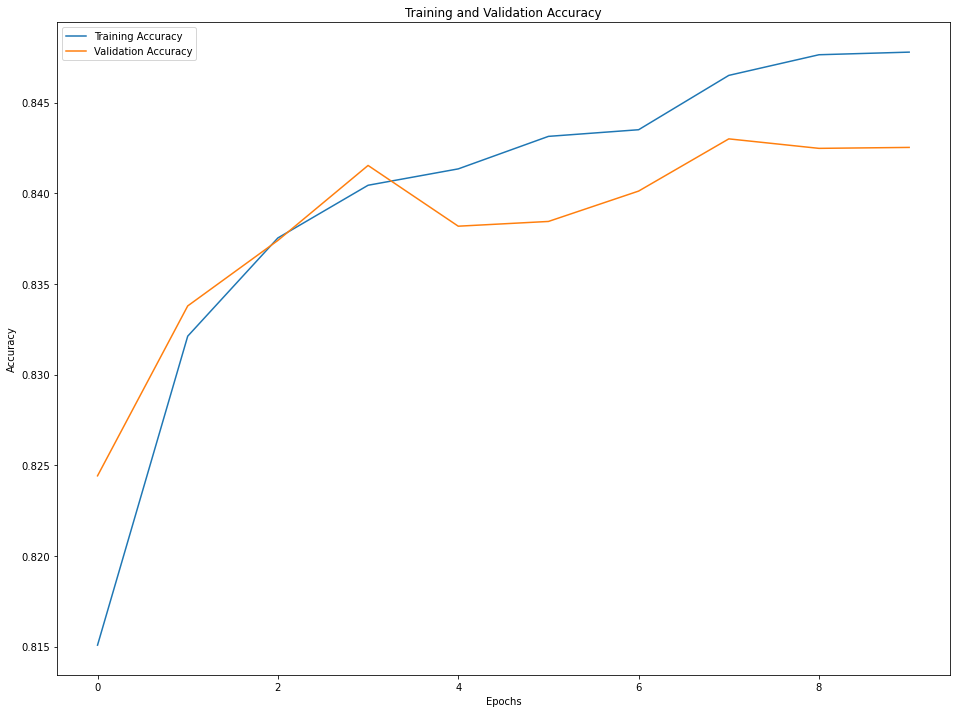

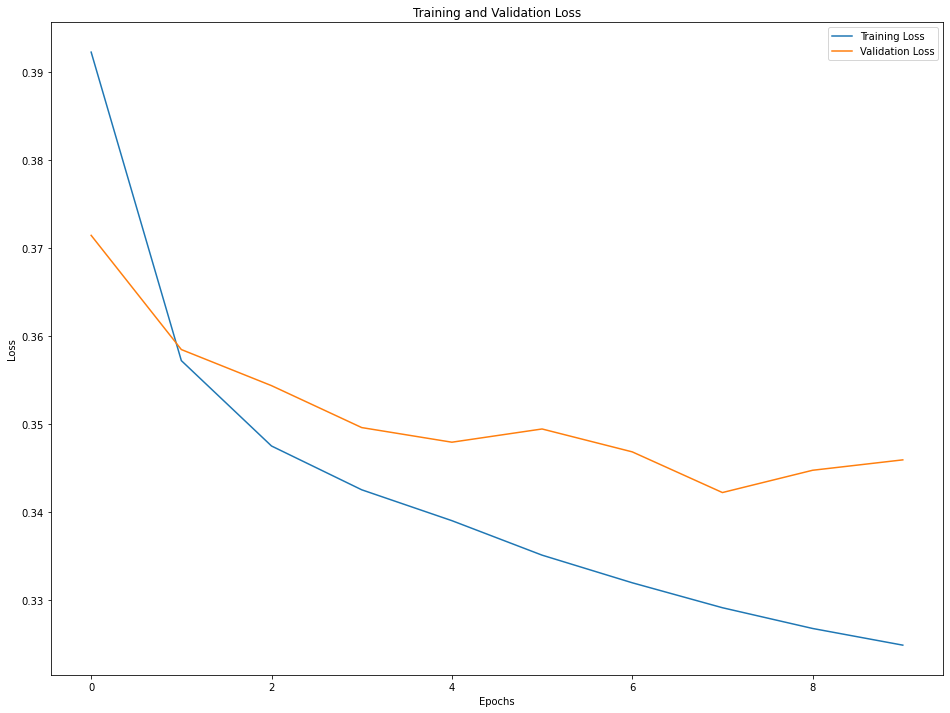

In [50]:
import tensorflow as tf
from tensorflow import keras
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (optional but can help with training performance)
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

# Define the input shape based on the number of features (54 columns)
input_shape = (X_train.shape[1],)

# Create a sequential model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=input_shape),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train_nn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
y_pred = model.predict(X_test_nn)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy and print the evaluation results
accuracy = accuracy_score(y_test, y_pred_binary)
confusion = confusion_matrix(y_test, y_pred_binary)
classification = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)

# Plot training and validation accuracy
plt.figure(figsize=(16, 12))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(16, 12))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                3520      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2388/2388 [==============================] - 5s 2ms/step - loss: 0.3902 - accuracy: 0.8152 - val_loss: 0.3679 - val_accuracy: 0.8281
Epoch 2/15
2388/2388 [==============================] - 4s 2ms/step - loss: 0.3567 - accuracy: 0.8307 - val_loss: 0.3599 - val_accuracy: 0.8311
Epoch 3/15
2388/2388 [======

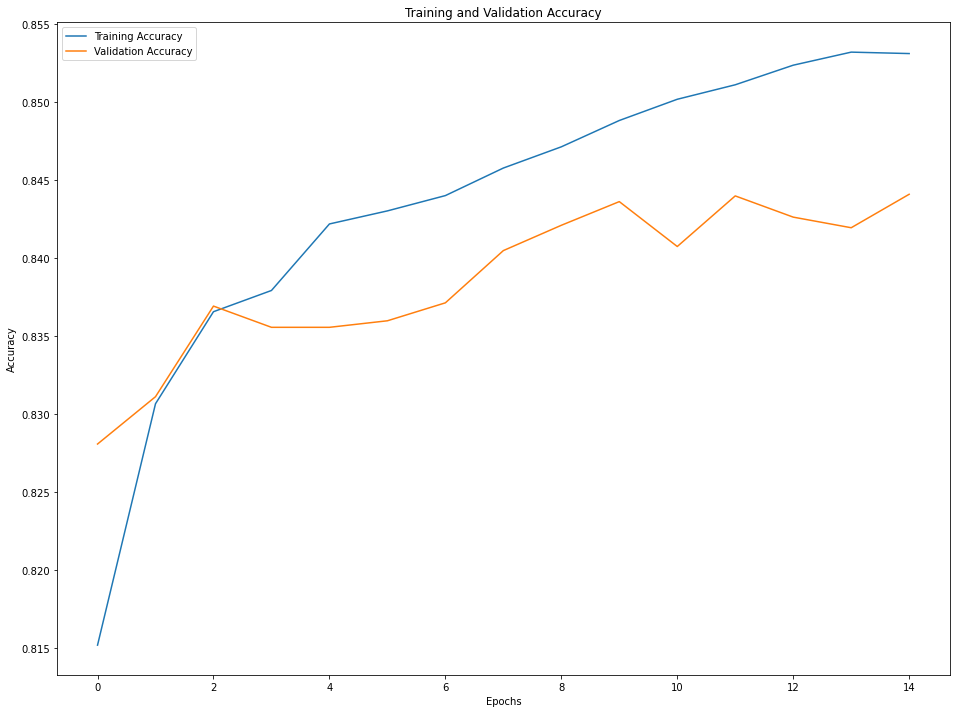

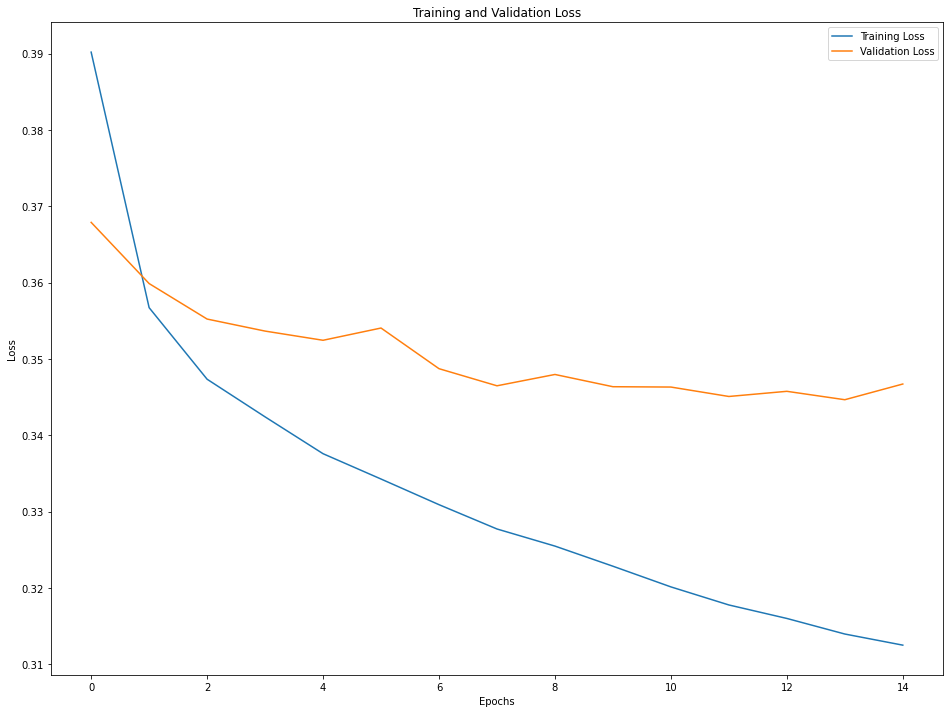

747/747 [==============================] - 1s 869us/step
Accuracy: 0.84483625094229
Confusion Matrix:
[[13627  1406]
 [ 2299  6546]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     15033
           1       0.82      0.74      0.78      8845

    accuracy                           0.84     23878
   macro avg       0.84      0.82      0.83     23878
weighted avg       0.84      0.84      0.84     23878



In [47]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (optional but can help with training performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the input shape based on the number of features (54 columns)
input_shape = (X_train.shape[1],)

# Create a sequential model
model = keras.Sequential([
    keras.layers.Dense(64, activation='gelu', input_shape=input_shape),
    keras.layers.Dense(32, activation='gelu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# Plot training and validation accuracy
plt.figure(figsize=(16, 12))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(16, 12))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy and print the evaluation results
accuracy = accuracy_score(y_test, y_pred_binary)
confusion = confusion_matrix(y_test, y_pred_binary)
classification = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)


Epoch 1/70
2687/2687 [==============================] - 5s 2ms/step - loss: 0.5010 - accuracy: 0.7809 - val_loss: 0.4514 - val_accuracy: 0.8151 - lr: 9.5123e-04
Epoch 2/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4403 - accuracy: 0.8169 - val_loss: 0.4311 - val_accuracy: 0.8195 - lr: 9.0484e-04
Epoch 3/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4270 - accuracy: 0.8211 - val_loss: 0.4234 - val_accuracy: 0.8232 - lr: 8.6071e-04
Epoch 4/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4206 - accuracy: 0.8249 - val_loss: 0.4211 - val_accuracy: 0.8244 - lr: 8.1873e-04
Epoch 5/70
2687/2687 [==============================] - 5s 2ms/step - loss: 0.4170 - accuracy: 0.8266 - val_loss: 0.4230 - val_accuracy: 0.8257 - lr: 7.7880e-04
Epoch 6/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4146 - accuracy: 0.8282 - val_loss: 0.4158 - val_accuracy: 0.8259 - lr: 7.4082e-04
Epoch 7/70
2687/2687 [============

Epoch 52/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4004 - accuracy: 0.8352 - val_loss: 0.4042 - val_accuracy: 0.8342 - lr: 7.4274e-05
Epoch 53/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4004 - accuracy: 0.8357 - val_loss: 0.4044 - val_accuracy: 0.8347 - lr: 7.0651e-05
Epoch 54/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4003 - accuracy: 0.8356 - val_loss: 0.4041 - val_accuracy: 0.8347 - lr: 6.7206e-05
Epoch 55/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4003 - accuracy: 0.8354 - val_loss: 0.4047 - val_accuracy: 0.8338 - lr: 6.3928e-05
Epoch 56/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4003 - accuracy: 0.8356 - val_loss: 0.4044 - val_accuracy: 0.8347 - lr: 6.0810e-05
Epoch 57/70
2687/2687 [==============================] - 4s 2ms/step - loss: 0.4002 - accuracy: 0.8355 - val_loss: 0.4042 - val_accuracy: 0.8336 - lr: 5.7844e-05
Epoch 58/70
2687/2687 [=====

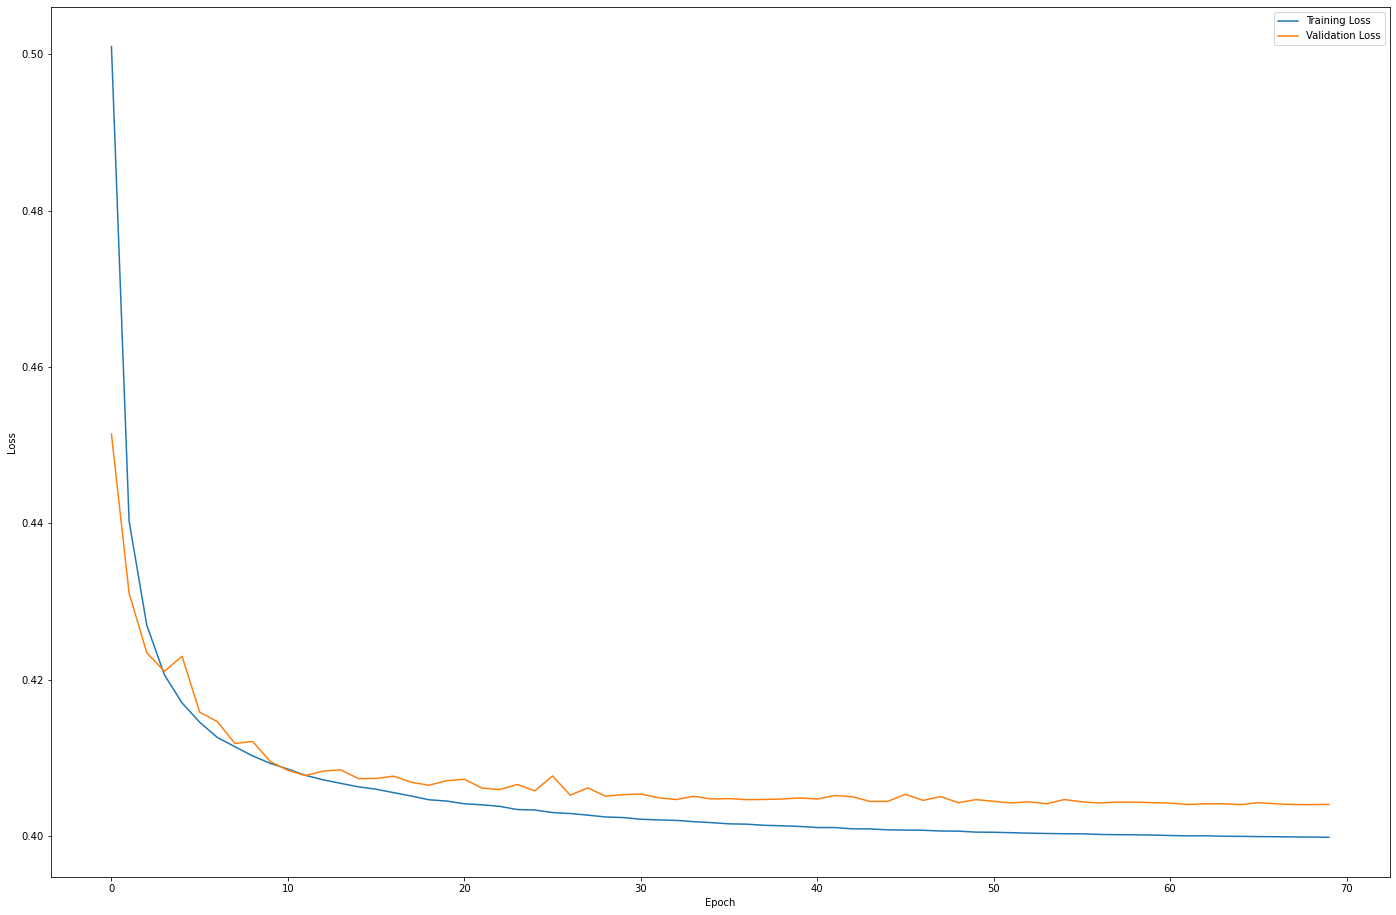

747/747 [==============================] - 1s 898us/step
Accuracy: 0.8380517631292403
Confusion Matrix:
[[13642  1265]
 [ 2602  6369]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88     14907
         1.0       0.83      0.71      0.77      8971

    accuracy                           0.84     23878
   macro avg       0.84      0.81      0.82     23878
weighted avg       0.84      0.84      0.84     23878



In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform standard scaling on the input features
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn = scaler.transform(X_test)

# Convert the labels to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Define the label smoothing factor (epsilon)
epsilon = 0.05

# Define the initial learning rate (you can adjust this value)
initial_learning_rate = 0.001

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='gelu', input_shape=(54,)),
    tf.keras.layers.Dense(8, activation='gelu'),
    tf.keras.layers.Dense(4, activation='gelu'),
    tf.keras.layers.Dense(2, activation='gelu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define the custom learning rate schedule
def learning_rate_scheduler(epoch, lr):
    # You can modify this function to change the learning rate over epochs
    return lr * tf.math.exp(-0.05)  # Example: decay learning rate by 0.1 every epoch

# Compile the model with the Adam optimizer and custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=epsilon),
              metrics=['accuracy'])

# Train the model with adjustable learning rate
history = model.fit(X_train_nn, y_train, epochs=70, batch_size=32, validation_split=0.1,
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_nn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test_nn)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy and print the evaluation results
accuracy = accuracy_score(y_test, y_pred_binary)
confusion = confusion_matrix(y_test, y_pred_binary)
classification = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification)

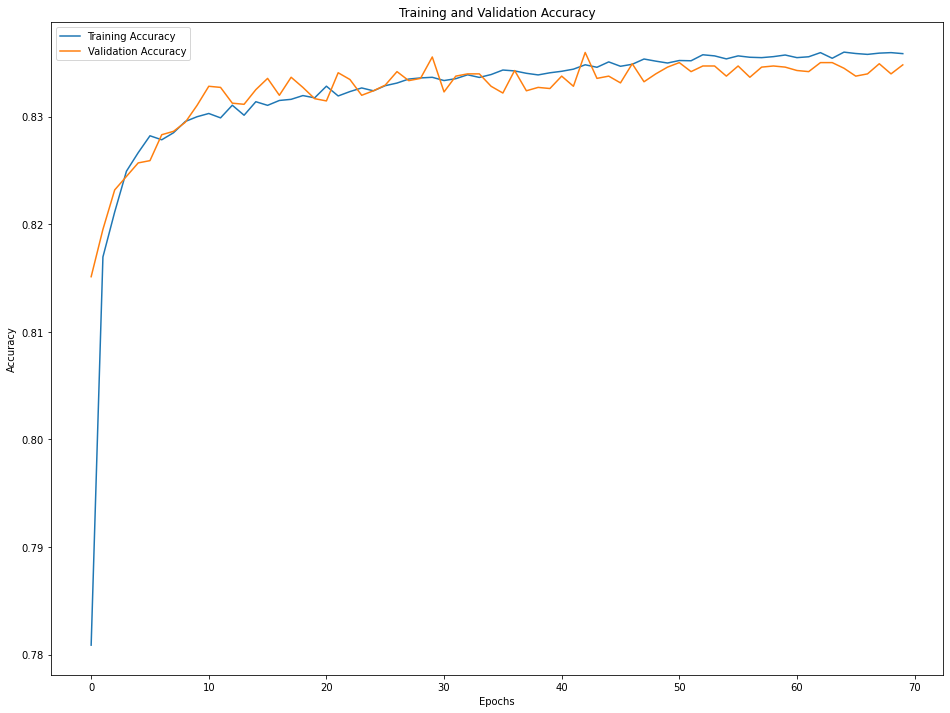

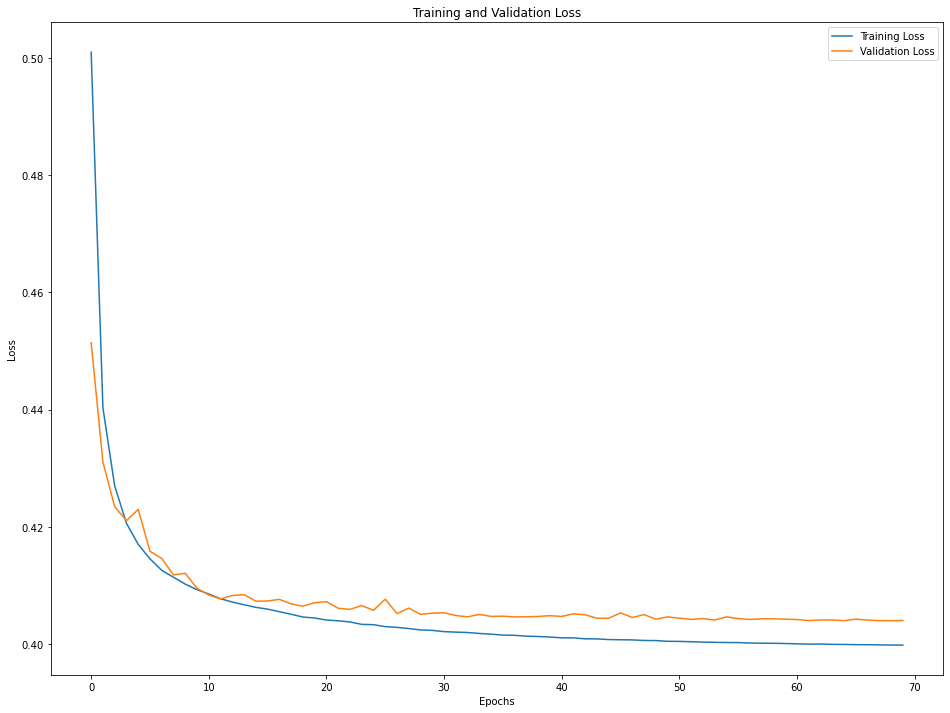

In [58]:
# Plot training and validation accuracy
plt.figure(figsize=(16, 12))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(16, 12))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [60]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape)
# Make predictions using the trained models
y_pred_logreg = result_logit.predict(sm.add_constant(X_test))
y_pred_rf = rf_classifier.predict(X_test)
y_pred_nn = model.predict(X_test_nn).ravel()

print(y_pred_logreg.shape)
print(y_pred_rf.shape)
print(y_pred_nn.shape)

# Convert the predictions to binary values using a threshold of 0.5
y_pred_logreg_binary = (y_pred_logreg >= 0.5).astype(int)
y_pred_rf_binary = (y_pred_rf >= 0.5).astype(int)
y_pred_nn_binary = (y_pred_nn >= 0.5).astype(int)

# Combine the predictions using majority voting
y_pred_ensemble = np.round((y_pred_logreg_binary + y_pred_rf_binary + y_pred_nn_binary) / 3).astype(int)

# Calculate accuracy and print the evaluation results for the ensemble
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
confusion_ensemble = confusion_matrix(y_test, y_pred_ensemble)
classification_ensemble = classification_report(y_test, y_pred_ensemble)

print("Ensemble Accuracy:", accuracy_ensemble)
print("Ensemble Confusion Matrix:")
print(confusion_ensemble)
print("\nEnsemble Classification Report:")
print(classification_ensemble)


(23878, 54)
747/747 [==============================] - 1s 937us/step
(23878,)
(23878,)
(23878,)
Ensemble Accuracy: 0.8658179076974621
Ensemble Confusion Matrix:
[[13927   980]
 [ 2224  6747]]

Ensemble Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90     14907
         1.0       0.87      0.75      0.81      8971

    accuracy                           0.87     23878
   macro avg       0.87      0.84      0.85     23878
weighted avg       0.87      0.87      0.86     23878

